# <a id='toc1_'></a>[海洋要素计算 编程作业4](#toc0_)
计算地转流  
- 1.利用两月的月平均资料计算北太平洋*6°N-35°N*范围内的地转流，选取**1500db**作为参考零面画出*10db*，*100 db*，*250 db*，*500 db*等四个深度层上的流场和流速
- 2.利用上面计算结果，计算北赤道流水体输运（如130°E，8°N-18°N断面），比较讨论两月结果差异，也可进一步比较不同断面的差异  
  
**Developed By [Hanxue Yu](https://github.com/Yuhan-xue) 02\06\2023**  
**Student ID: 20010006082**

**目录**<a id='toc0_'></a>    
- [海洋要素计算 编程作业4](#toc1_)    
  - [Import Module](#toc1_1_)    
  - [NC file Read&Load](#toc1_2_)    
    - [Read](#toc1_2_1_)    
    - [Load](#toc1_2_2_)    
  - [2018 01](#toc1_3_)    
    - [Calculate Lattice Distance and Coriolis Parameters](#toc1_3_1_)    
    - [Calculates specific volume anomaly](#toc1_3_2_)    
    - [Calculate Gravity Potential Anomalies](#toc1_3_3_)    
    - [Calculate Geostrophic Flow](#toc1_3_4_)    
      - [切割数据至1500 db以上 6°N~35°N区域](#toc1_3_4_1_)    
      - [计算](#toc1_3_4_2_)    
    - [Calculate For Transport (sv)](#toc1_3_5_)    
      - [原理阐释](#toc1_3_5_1_)    
      - [Calculate & Visualization](#toc1_3_5_2_)    
    - [Visualization of Flow Velocity & Flow Field](#toc1_3_6_)    
  - [2018 07](#toc1_4_)    
    - [Calculate Lattice Distance and Coriolis Parameters](#toc1_4_1_)    
    - [Calculates specific volume anomaly](#toc1_4_2_)    
    - [Calculate Gravity Potential Anomalies](#toc1_4_3_)    
    - [Calculate Geostrophic Flow](#toc1_4_4_)    
      - [切割数据至1500 db以上 6°N~35°N区域](#toc1_4_4_1_)    
      - [计算](#toc1_4_4_2_)    
    - [Calculate For Transport (sv)](#toc1_4_5_)    
    - [Visualization of Flow Velocity & Flow Field](#toc1_4_6_)    
  - [Compare](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Import Module](#toc0_)

In [1]:
import gsw
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

## <a id='toc1_2_'></a>[NC file Read&Load](#toc0_)

### <a id='toc1_2_1_'></a>[Read](#toc0_)

In [2]:
# NC 文件加载与信息提取
das1=nc.Dataset('TS_201801_GLB.nc')
das2=nc.Dataset('TS_201807_GLB.nc')
def getNCinfo(das):
    for i in list(das.variables.keys()):
        ignolist=['time','lat','lon','LONGITUDE', 'LATITUDE', 'TIME', 'bnds','err','ERR','error','ERROR']
        if i in ignolist or i.split('_')[-1] in ignolist:
            continue
        print(f'Key: {i}')
        print(f'    | Long Name: {das.variables[i].long_name}')
        print(f'    | Units: {das.variables[i].units}')
        print(f'    | Shape: {das.variables[i].shape}')
getNCinfo(das1)

Key: PRES
    | Long Name: Pressure
    | Units: decibar
    | Shape: (25,)
Key: TOI
    | Long Name: Temperature.(ITS90)
    | Units: degree_Celsius
    | Shape: (25, 132, 360)
Key: SOI
    | Long Name: Salinity.(PSS-78)
    | Units: psu
    | Shape: (25, 132, 360)


### <a id='toc1_2_2_'></a>[Load](#toc0_)

In [3]:
# 变量加载
## 读取
DB_01=np.array(das1.variables['PRES'])
lev=np.array(das1.variables['PRES'])
TOI_01=np.array(das1.variables['TOI'])
SOI_01=np.array(das1.variables['TOI'])
DB_07=np.array(das2.variables['PRES'])
TOI_07=np.array(das2.variables['TOI'])
SOI_07=np.array(das2.variables['TOI'])
lon=np.array(das1.variables['LONGITUDE'])
lat=np.array(das1.variables['LATITUDE'])
## 处理
lon[lon<0]=lon[lon<0]+360
SOI_01[SOI_01>1000]=np.nan
TOI_01[TOI_01>1000]=np.nan
SOI_07[SOI_07>1000]=np.nan
TOI_07[TOI_07>1000]=np.nan
DB_01=np.broadcast_to(DB_01[:,np.newaxis,np.newaxis],SOI_01.shape)
DB_07=np.broadcast_to(DB_07[:,np.newaxis,np.newaxis],SOI_07.shape)

## <a id='toc1_3_'></a>[2018 01](#toc0_)

### <a id='toc1_3_1_'></a>[Calculate Lattice Distance and Coriolis Parameters](#toc0_)

In [4]:
# 计算格点距离和科氏参数
def getdx(lon):
    dx=np.zeros(len(lon))
    dx[:-1]=111e4*(lon[1:]-lon[:-1])
    return np.abs(dx[:-1])
def getdy(lat):
    dy=np.zeros(len(lat))
    dy[:-1]=111e4*(lat[1:]-lat[:-1])*np.cos(lat[:-1]*np.pi/180)
    return np.abs(dy[:-1])
def getCoriolisParm(lat):
    return 2 * 7.29e-5 * np.sin(np.radians(lat))
dx,dy,f=getdx(lon),getdy(lat),getCoriolisParm(lat)

### <a id='toc1_3_2_'></a>[Calculates specific volume anomaly](#toc0_)
查询[GSW-Python](https://teos-10.github.io/GSW-Python/gsw_flat.html)文档中gsw.specvol_anom_standard描述与用法
- 描述
    - Calculates specific volume anomaly from Absolute Salinity, Conservative Temperature and pressure. It uses the computationally-efficient expression for specific volume as a function of SA, CT and p (Roquet et al., 2015). The reference value to which the anomaly is calculated has an Absolute Salinity of SSO and Conservative Temperature equal to 0 degrees C. 
- 输入参数  
    - SA : Absolute Salinity, g/kg  
    - CT : Conservative Temperature (ITS-90), degrees C  
    - p : Sea pressure (absolute pressure minus 10.1325 dbar), dbar  
- 返回参数
    - specvol_anom : specific volume anomaly, m^3/kg

In [5]:
# 计算比容异常<使用了GSW-Python模块>
sva = gsw.specvol_anom_standard(SA=SOI_01, CT=TOI_01, p=DB_01)*10e3 # 单位转换为cm^3/g

### <a id='toc1_3_3_'></a>[Calculate Gravity Potential Anomalies](#toc0_)

In [6]:
RefLevel=1500
lastind=np.where(lev==RefLevel)[0][0]+1
def getgpa(dat):
    global lev
    dd=(dat[1:lastind]+dat[:lastind-1])/2*(lev[1:lastind]-lev[:lastind-1])
    return np.append(np.cumsum(dd[::-1])[::-1],[0])
def getsigma(dat):
    return dat[1:]-dat[:-1]
gpa=np.apply_along_axis(getgpa, axis=0, arr=sva)
Δgpa_x=np.apply_along_axis(getsigma, axis=2, arr=gpa)
Δgpa_y=np.apply_along_axis(getsigma, axis=1, arr=gpa)

### <a id='toc1_3_4_'></a>[Calculate Geostrophic Flow](#toc0_)

#### <a id='toc1_3_4_1_'></a>[切割数据至1500 db以上 6°N~35°N区域](#toc0_)

In [7]:
RefLevel=1500
levind=lev<=RefLevel
latind=(lat>=6)&(lat<=35)
lonind=(lon>=100)&(lon<265)
sva=sva[levind,:,:][:,latind,:][:,:,lonind]
dy=dy[latind[1:]]
f=f[latind]
lev=lev[levind]
Δgpa_x=Δgpa_x[:,latind,:][:,:,lonind[1:]]
Δgpa_y=Δgpa_y[:,latind[1:],:][:,:,lonind]
f=np.broadcast_to(f[np.newaxis,:,np.newaxis],Δgpa_x.shape)
dx=np.broadcast_to(dx[np.newaxis,np.newaxis,lonind[1:]],Δgpa_x.shape)
dy=np.broadcast_to(dy[np.newaxis,:,np.newaxis],Δgpa_x.shape)
lon=lon[lonind]
lat=lat[latind]

#### <a id='toc1_3_4_2_'></a>[计算](#toc0_)

In [8]:
U=-1*(1/(f*dy))*Δgpa_y
V=-1*(1/(f*dx))*Δgpa_x

### <a id='toc1_3_5_'></a>[Calculate For Transport (sv)](#toc0_)

#### <a id='toc1_3_5_1_'></a>[原理阐释](#toc0_)
计算每个网格面积： 
$$
\Delta {Lat} = |\ Lat_2 - Lat_1\ | \\
d_{Depth} = \Delta Depth \times 1000 \\
d_{Lat} = \Delta {Lat} \times \cos(Lat) \times 111000\\
Area = d_{Lat} \times d_{Depth} 
$$

计算每个网格的流水通量： 
$$
Flux=V \times Area
$$

计算每个纬度的流水通量： 
$$
F = \sum_{i=1}^{N_L} Flux_i
$$

其中，$Area$和$Flux$均为二维数组，每一行代表一个纬度，每个元素分别代表一个深度和经度对应的网格面积和流水通量。$F$为一维数组，每个元素代表每个纬度的流水通量。

#### <a id='toc1_3_5_2_'></a>[Calculate & Visualization](#toc0_)

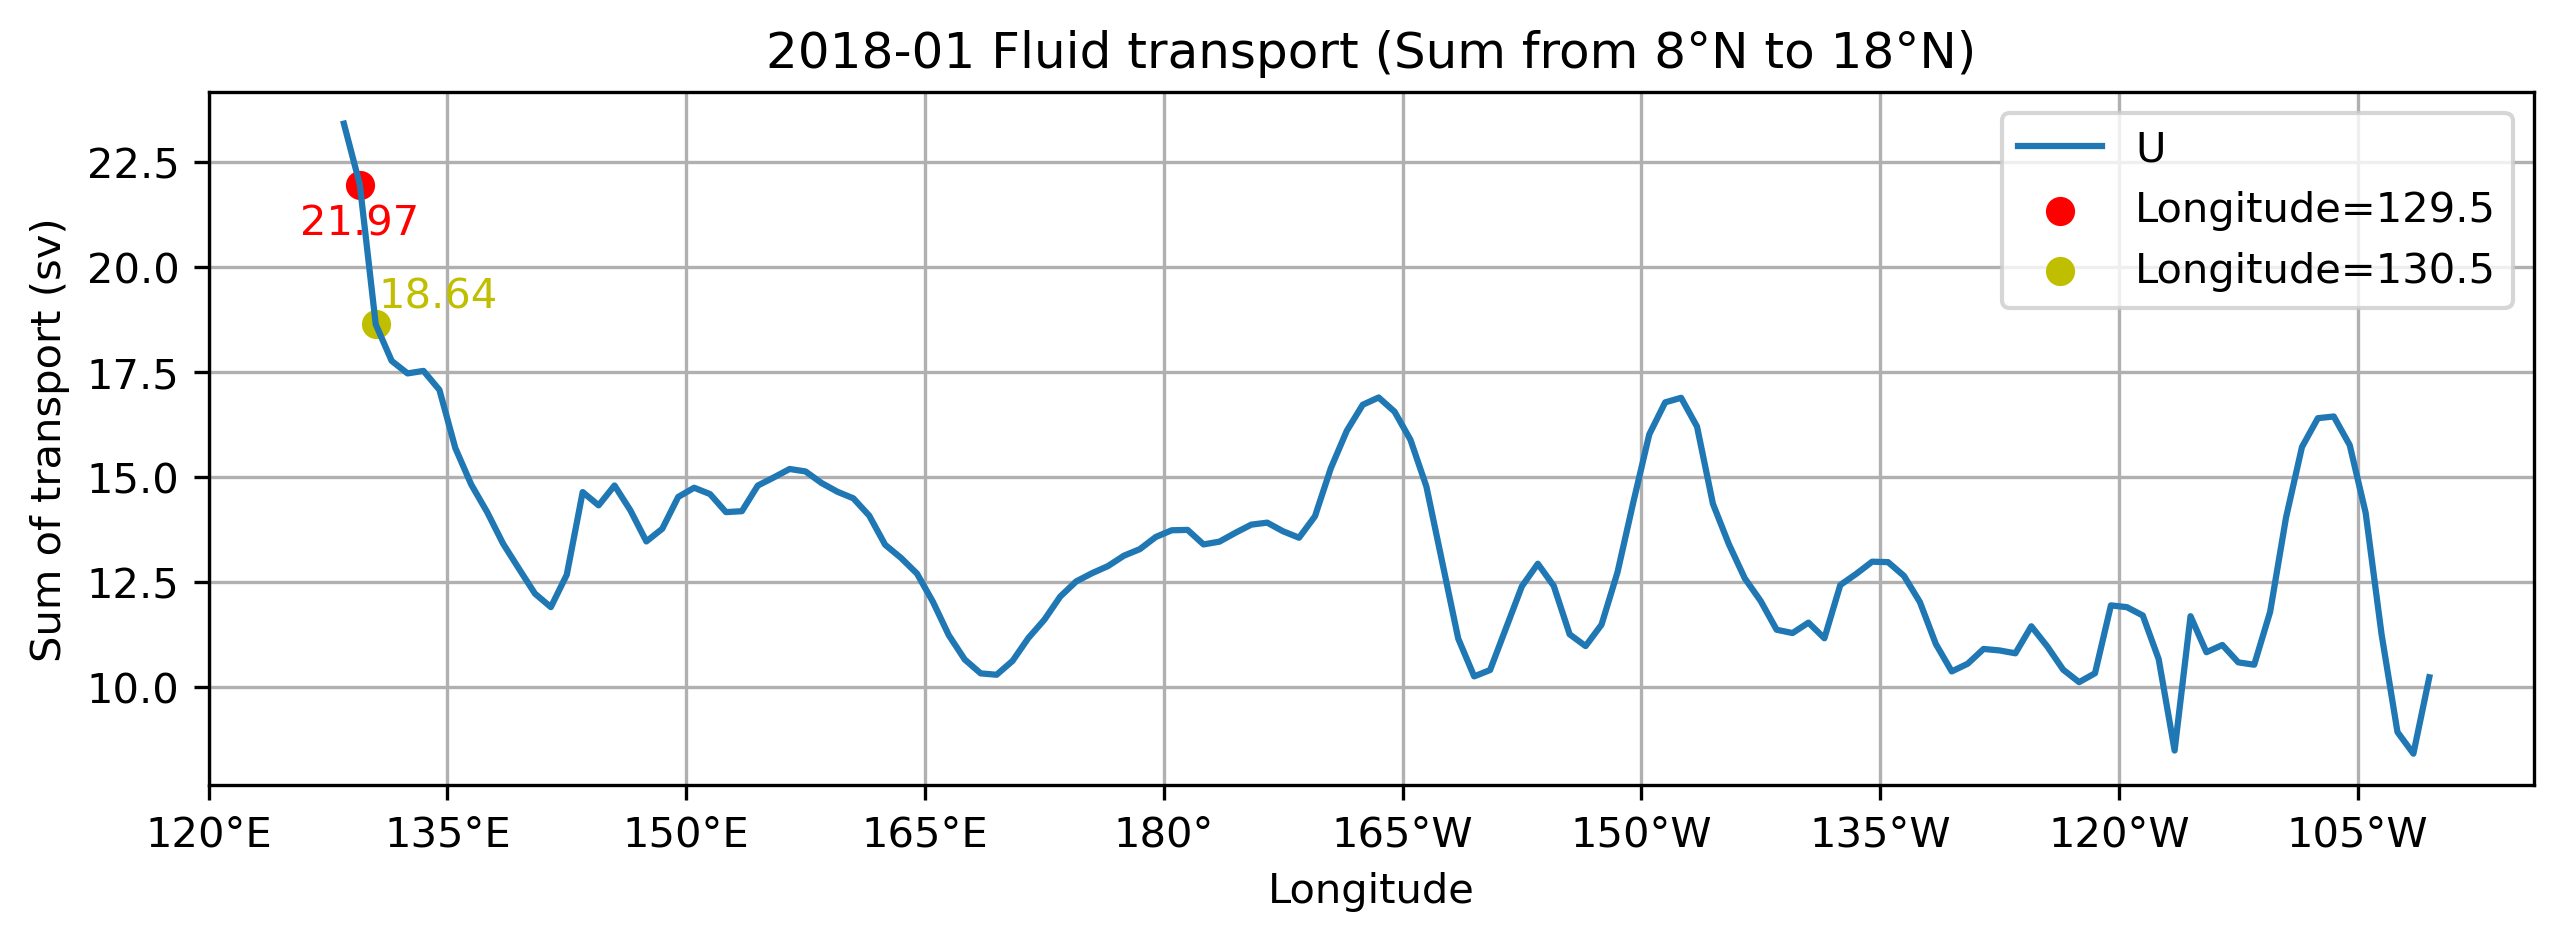

In [9]:
def calculate_flux_v1(v, lat, depth):
    """
    计算纬度平面的流水通量
    :param v: 垂直流速，二维numpy数组，行表示纬度，列表示深度
    :param lat: 纬度，一维numpy数组
    :param depth: 深度，一维numpy数组，单位为db
    :return: 纬度平面的流水通量，单位为sv
    """
    #print(v.shape)
    # 计算每个网格面积
    d_depth = np.diff(depth)
    area = getdy(lat)[:, np.newaxis] * d_depth[np.newaxis, :]
    flux = np.multiply(v[:-1,:-1].T, area)
    # 计算每个网格的流水通量
    return np.sum(flux)/10e6

latind=(lat>=8)&(lat<=18)
lat_t=lat[latind]
latind=(lat>=8)&(lat<=18)
lonind=(lon>=129)&(lon<=131)
lat_t=lat[latind]
ts_U = np.array([calculate_flux_v1((((U**2+V**2)**0.5)[:,latind,:][:,:,lon==i]),lat_t,lev) for i in lon])
#ts_V = np.array([calculate_flux_v1((V[:,latind,:][:,:,lon==i]),lat_t,lev) for i in lon])
plt.figure(figsize=(10,3),dpi=300)
plt.title('2018-01 Fluid transport (Sum from 8°N to 18°N)')
plt.plot(lon,ts_U,label='U')
plt.scatter(lon[lon==129.5],ts_U[lon==129.5],c='r',label='Longitude=129.5')
plt.scatter(lon[lon==130.5],ts_U[lon==130.5],c='y',label='Longitude=130.5')
plt.legend()
plt.annotate(
    f"{ts_U[lon == 129.5][0]:.2f}",
    (lon[lon == 129.5], ts_U[lon == 129.5]),
    textcoords="offset points",
    xytext=(0, -12),
    ha='center',
    c='r',
)
plt.annotate(
    f"{ts_U[lon == 130.5][0]:.2f}",
    (lon[lon == 130.5], ts_U[lon == 130.5]),
    textcoords="offset points",
    xytext=(15, 4),
    ha='center',
    c='y',
)
ax=plt.gca()
ax.get_xlim()
plt.xticks(np.arange(120,266,15),['120°E','135°E','150°E','165°E','180°','165°W','150°W','135°W','120°W','105°W'])
plt.xlabel('Longitude')
plt.ylabel('Sum of transport (sv)')
plt.grid()
np.save('ts_U_2018_01.npy',ts_U)

### <a id='toc1_3_6_'></a>[Visualization of Flow Velocity & Flow Field](#toc0_)

[None, None, None, None]

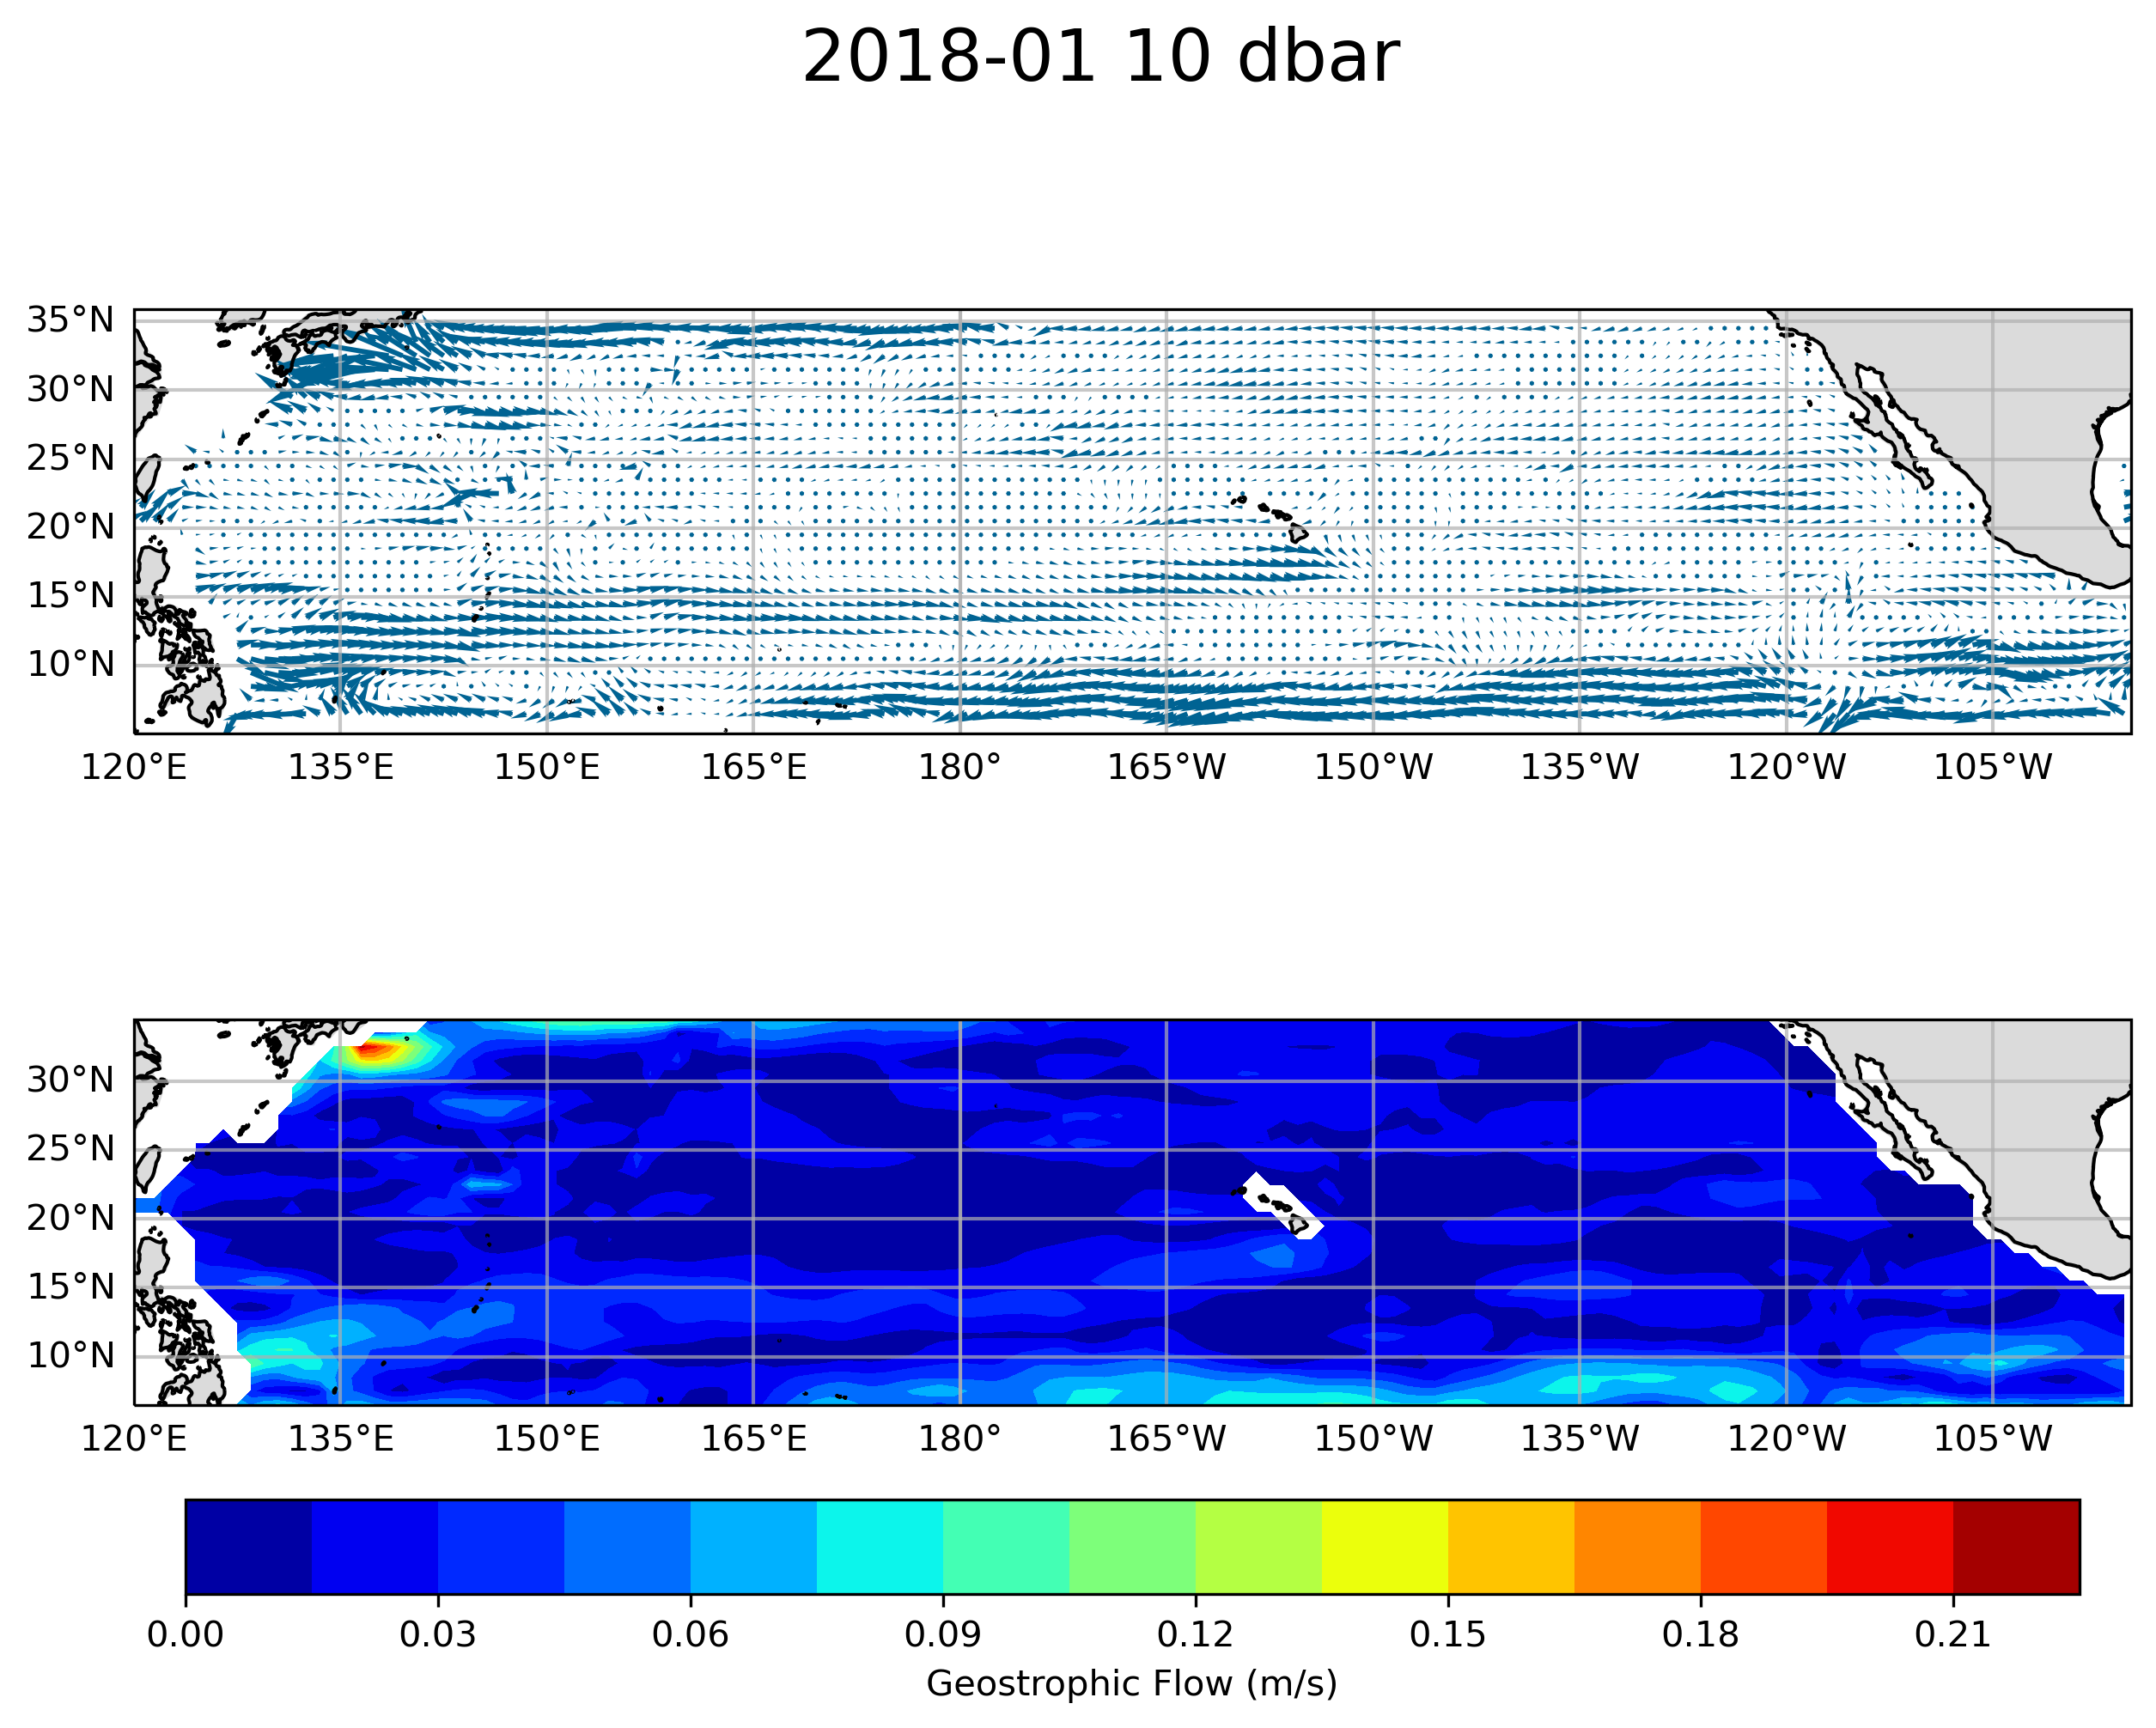

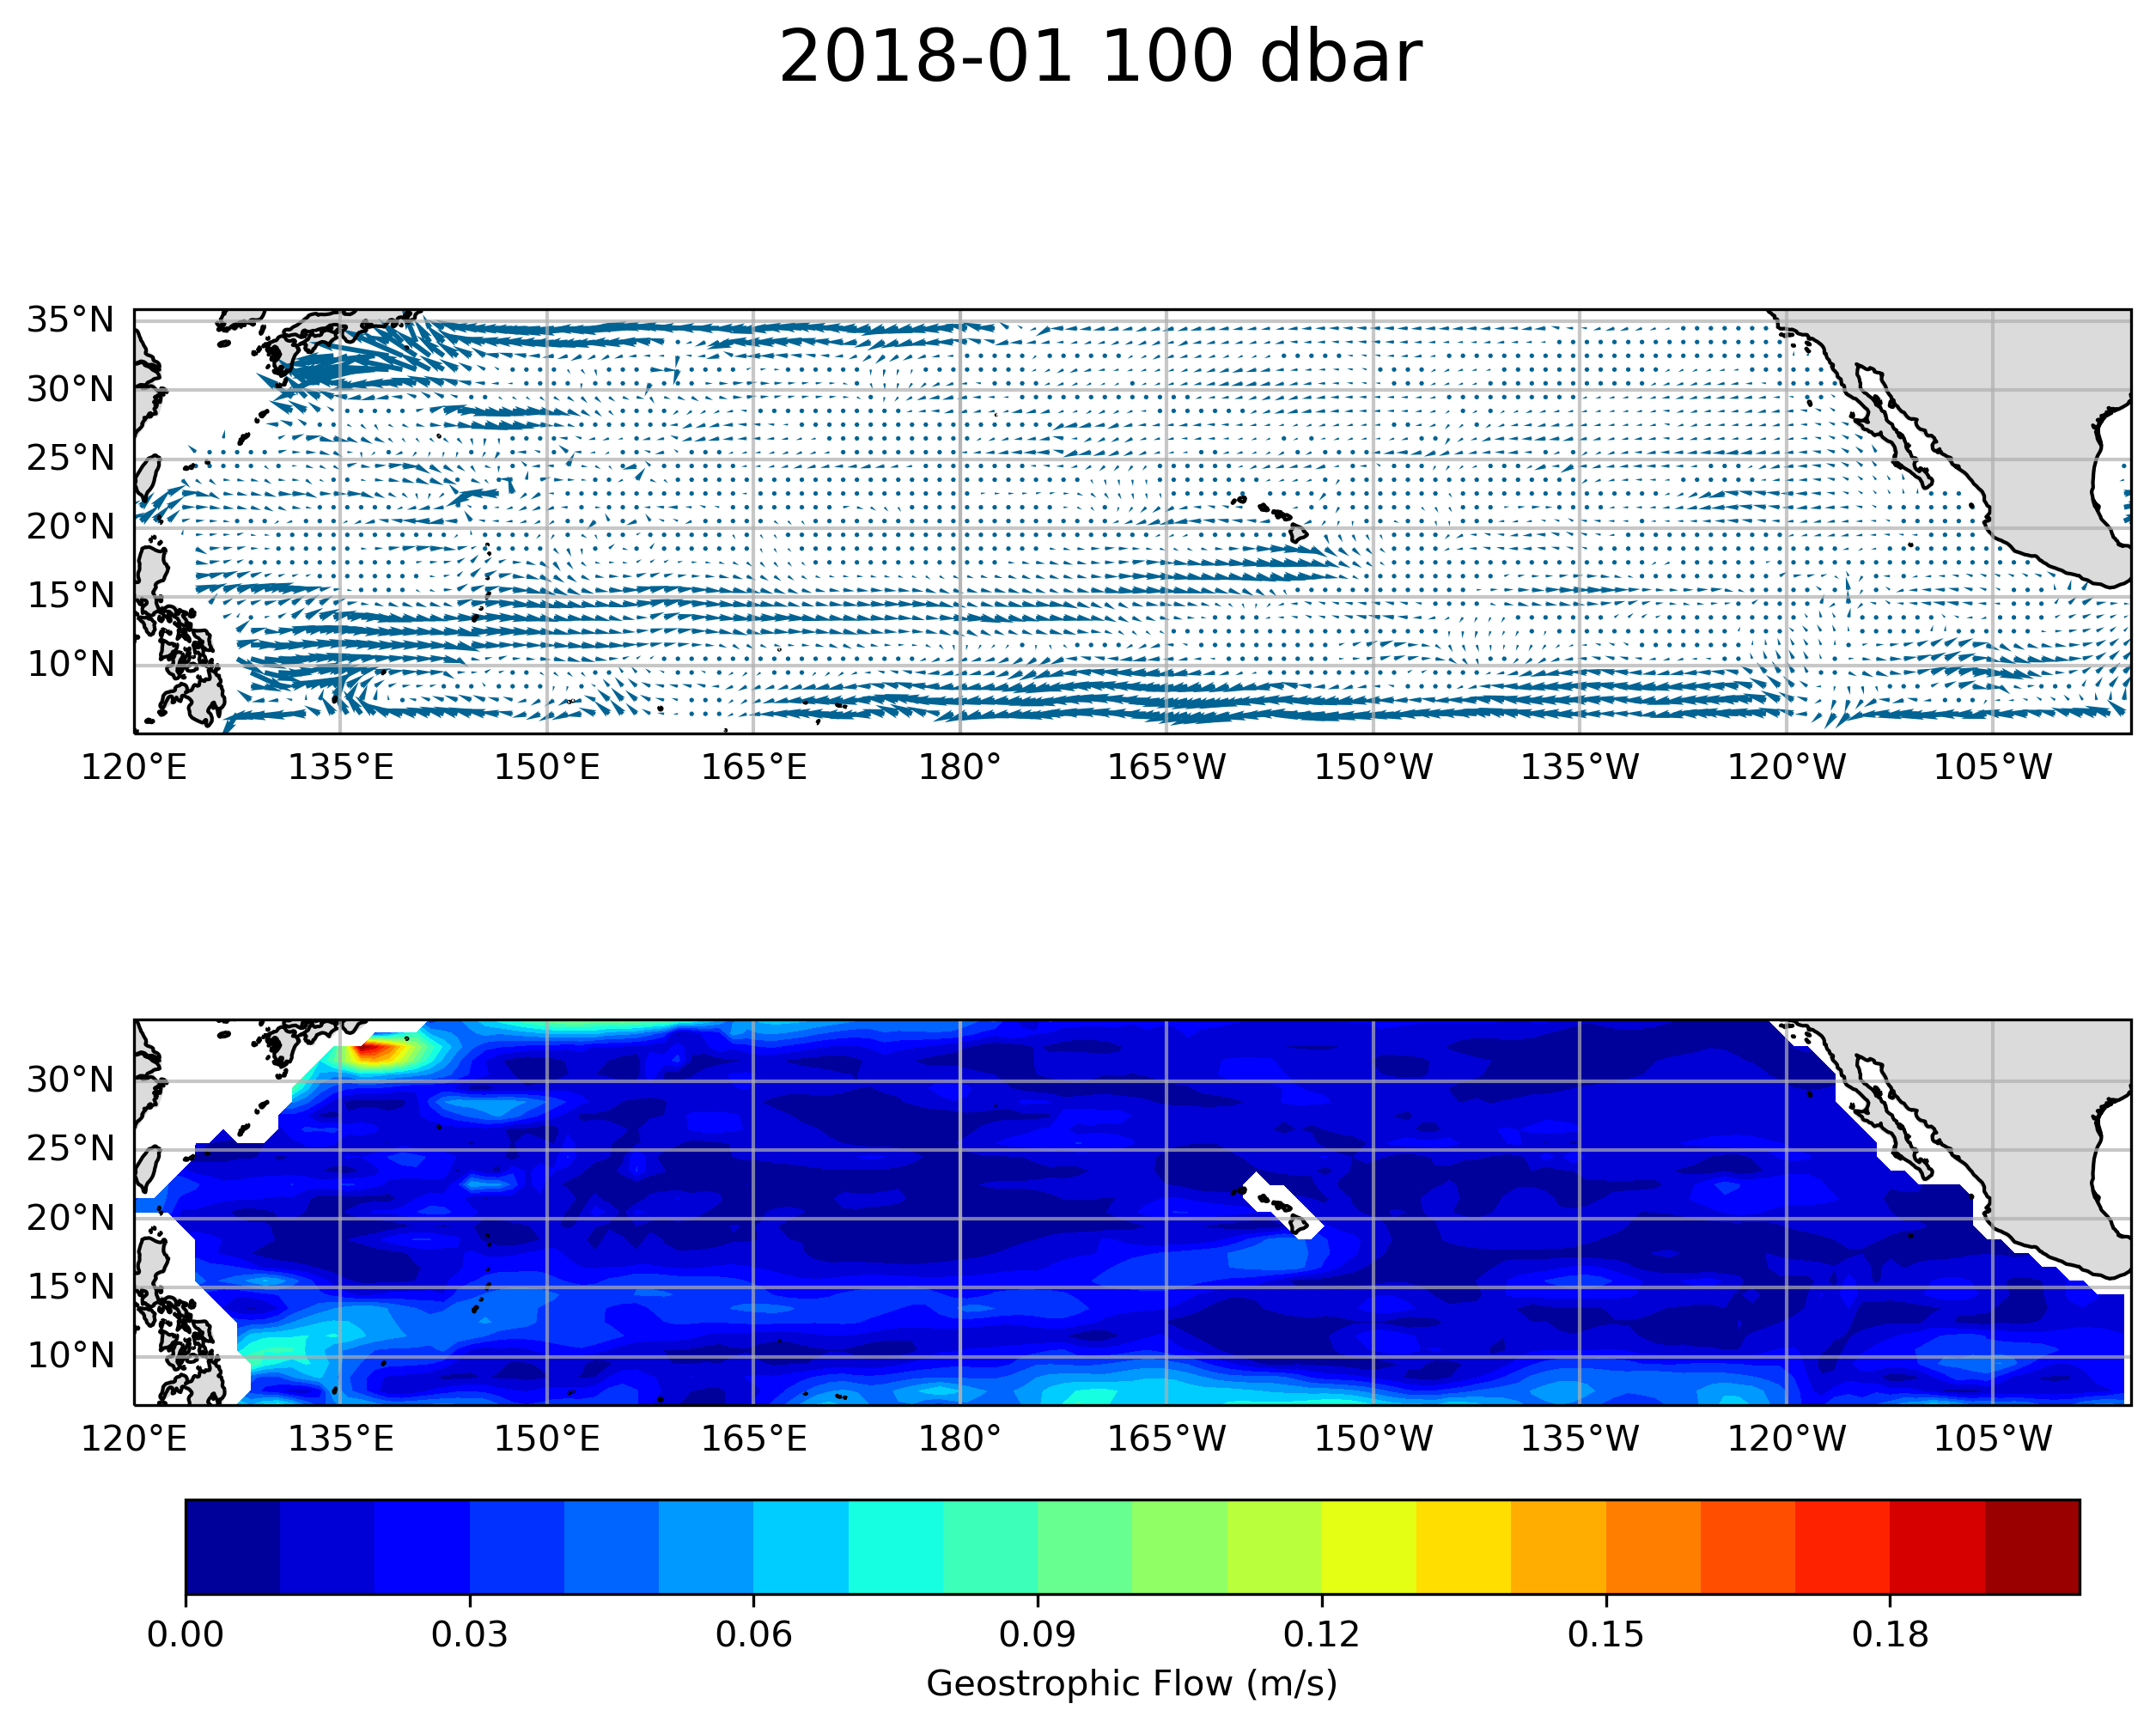

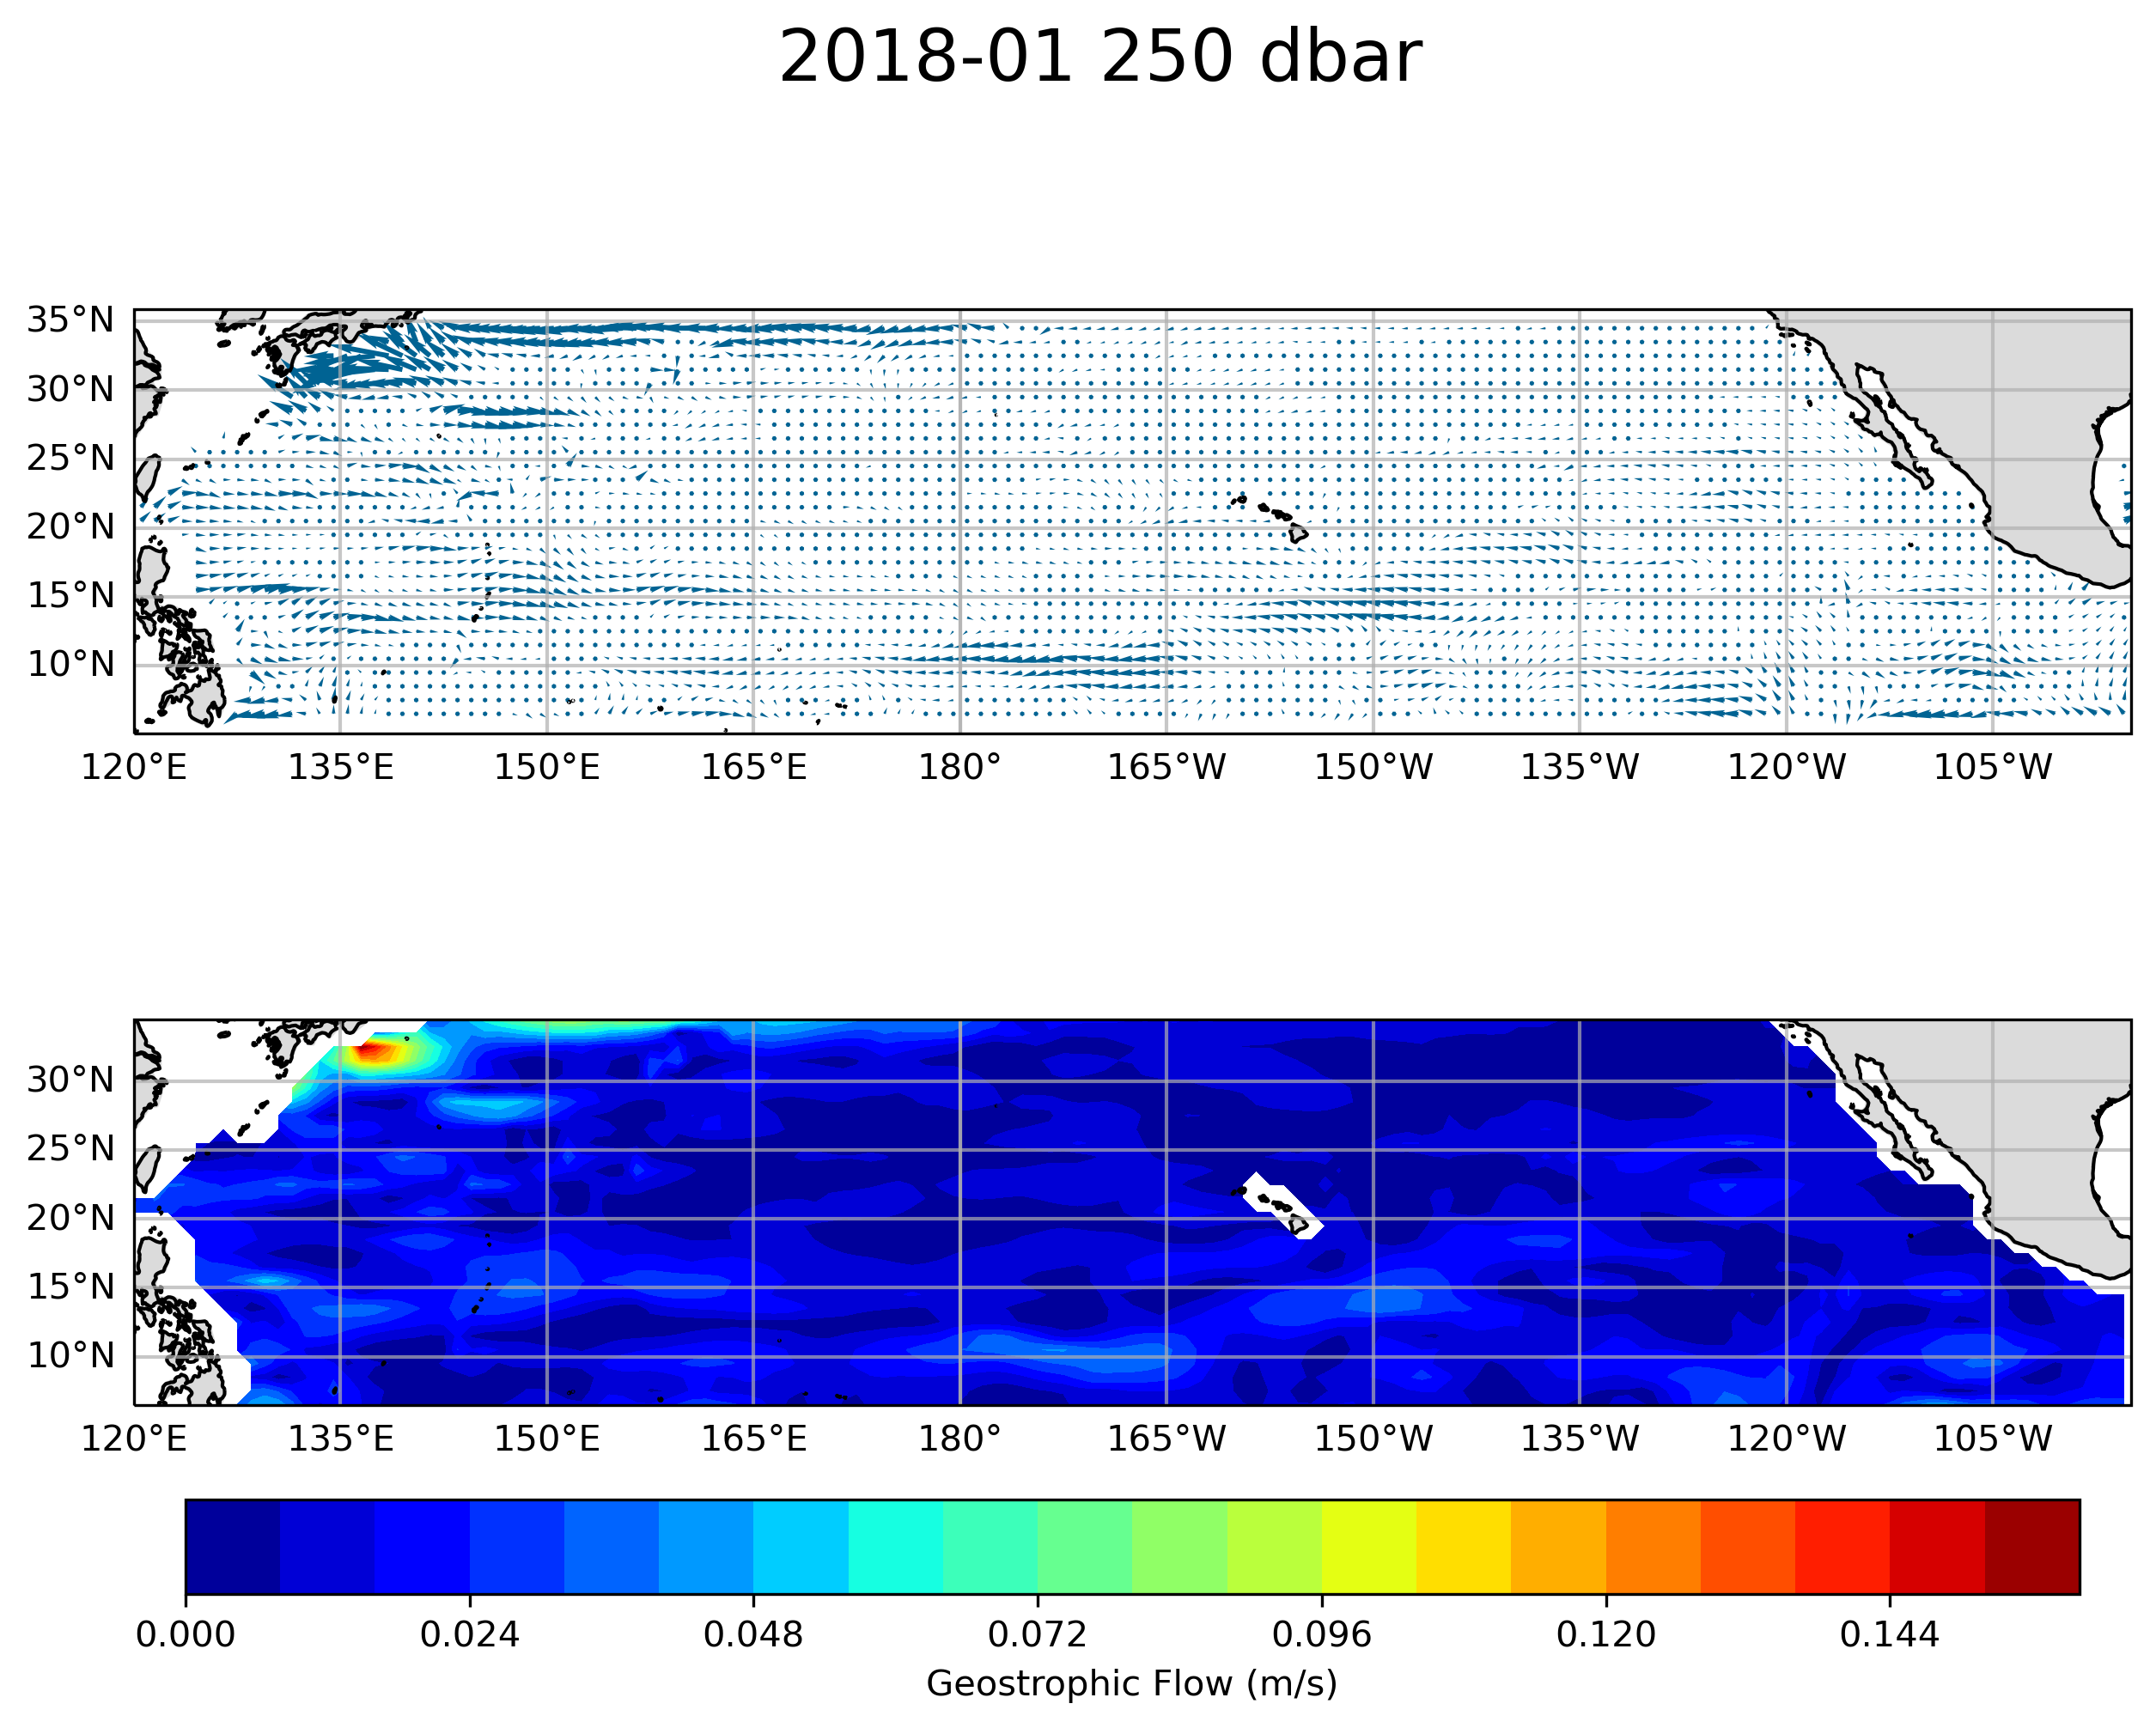

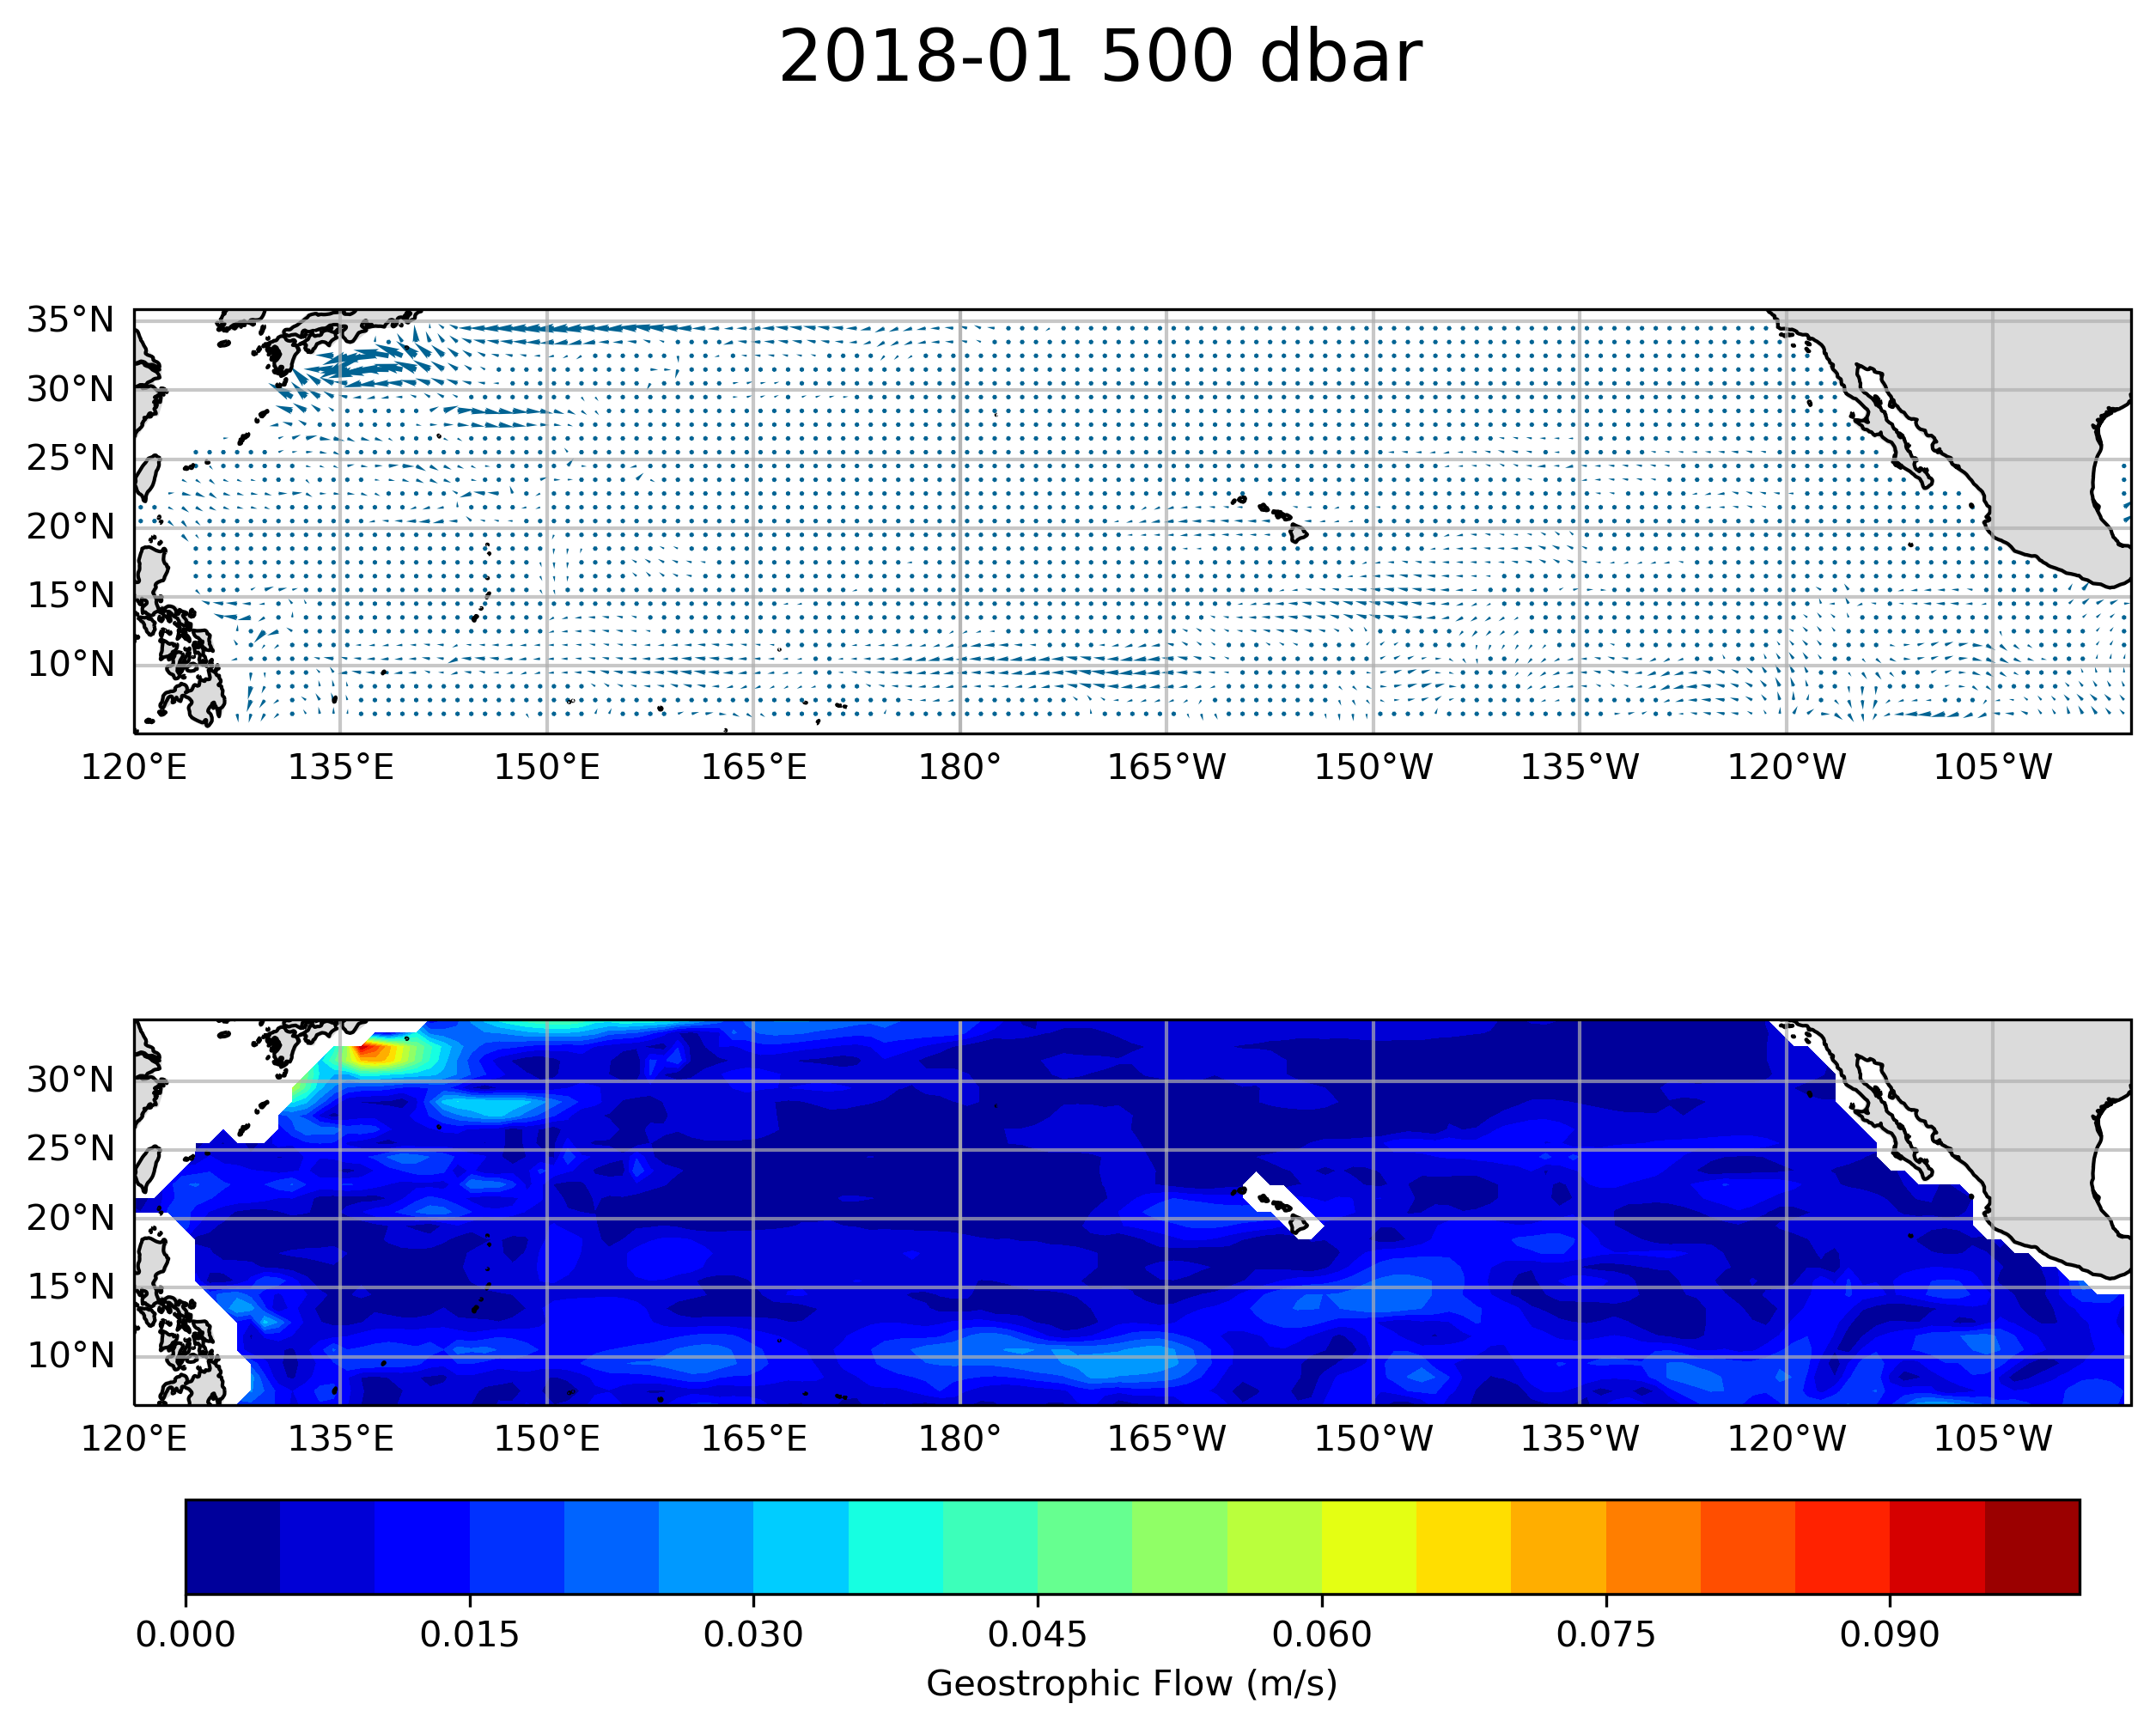

In [10]:

def draw(db):
    global U,V
    dbind=np.where(lev==db)[0][0]
    Lon,Lat=np.meshgrid(lon,lat)
    sep=1
    ig, axs = plt.subplots(2,1,figsize=(10,7),dpi=300,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    ig.suptitle(f'2018-01 {db} dbar',fontsize=20)
    for ax in axs:
        ax.coastlines()
        land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face',
                                        facecolor=cfeature.COLORS['land_alt1'])
        ax.add_feature(land, zorder=0)
        gl = ax.gridlines( draw_labels=True, linewidth=1, alpha=0.7)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = plt.MaxNLocator(29)
        ax.set_xlim(-60,85)
    # gl.ylocator = plt.MaxNLocator(6)
    axs[0].quiver(Lon[::sep,::sep],Lat[::sep,::sep],U[dbind,:,:][::sep,::sep],V[dbind,:,:][::sep,::sep],width=0.0025,headwidth=2,scale=4,transform=ccrs.PlateCarree(),color='#006393')
    c=axs[1].contourf(Lon,Lat,((U**2+V**2)**0.5)[dbind,:,:],20,cmap='jet',transform=ccrs.PlateCarree())
    plt.colorbar(c,orientation='horizontal',ax=axs[1],label='Geostrophic Flow (m/s)')
    plt.savefig(f'2018-01 {db} dbar.png',bbox_inches='tight')

dbs=[10,100,250,500]
[draw(db) for db in dbs]
#draw(10)

#ax.gridlines()
#plt.contourf(Lon,Lat,V[0,:,:],cmap='RdBu_r')
#plt.colorbar()

## <a id='toc1_4_'></a>[2018 07](#toc0_)

### <a id='toc1_4_1_'></a>[Calculate Lattice Distance and Coriolis Parameters](#toc0_)

In [11]:
# 还原2018-01计算改变的变量
lon=np.array(das2.variables['LONGITUDE'])
lat=np.array(das2.variables['LATITUDE'])
lon[lon<0]=lon[lon<0]+360
lev=np.array(das2.variables['PRES'])
# 计算格点距离和科氏参数
dx,dy,f=getdx(lon),getdy(lat),getCoriolisParm(lat)

### <a id='toc1_4_2_'></a>[Calculates specific volume anomaly](#toc0_)

In [12]:
# 计算比容异常<使用了GSW-Python模块>
sva = gsw.specvol_anom_standard(SA=SOI_07, CT=TOI_07, p=DB_07)*10e3 # 单位转换为cm^3/g

### <a id='toc1_4_3_'></a>[Calculate Gravity Potential Anomalies](#toc0_)

In [13]:
RefLevel=1500
lastind=np.where(lev==RefLevel)[0][0]+1
gpa=np.apply_along_axis(getgpa, axis=0, arr=sva)
Δgpa_x=np.apply_along_axis(getsigma, axis=2, arr=gpa)
Δgpa_y=np.apply_along_axis(getsigma, axis=1, arr=gpa)

### <a id='toc1_4_4_'></a>[Calculate Geostrophic Flow](#toc0_)
#### <a id='toc1_4_4_1_'></a>[切割数据至1500 db以上 6°N~35°N区域](#toc0_)

In [14]:
RefLevel=1500
levind=lev<=RefLevel
latind=(lat>=6)&(lat<=35)
lonind=(lon>=100)&(lon<265)
sva=sva[levind,:,:][:,latind,:][:,:,lonind]
dy=dy[latind[1:]]
f=f[latind]
lev=lev[levind]
Δgpa_x=Δgpa_x[:,latind,:][:,:,lonind[1:]]
Δgpa_y=Δgpa_y[:,latind[1:],:][:,:,lonind]
f=np.broadcast_to(f[np.newaxis,:,np.newaxis],Δgpa_x.shape)
dx=np.broadcast_to(dx[np.newaxis,np.newaxis,lonind[1:]],Δgpa_x.shape)
dy=np.broadcast_to(dy[np.newaxis,:,np.newaxis],Δgpa_x.shape)
lon=lon[lonind]
lat=lat[latind]

#### <a id='toc1_4_4_2_'></a>[计算](#toc0_)

In [15]:
U=-1*(1/(f*dy))*Δgpa_y
V=-1*(1/(f*dx))*Δgpa_x

### <a id='toc1_4_5_'></a>[Calculate For Transport (sv)](#toc0_)

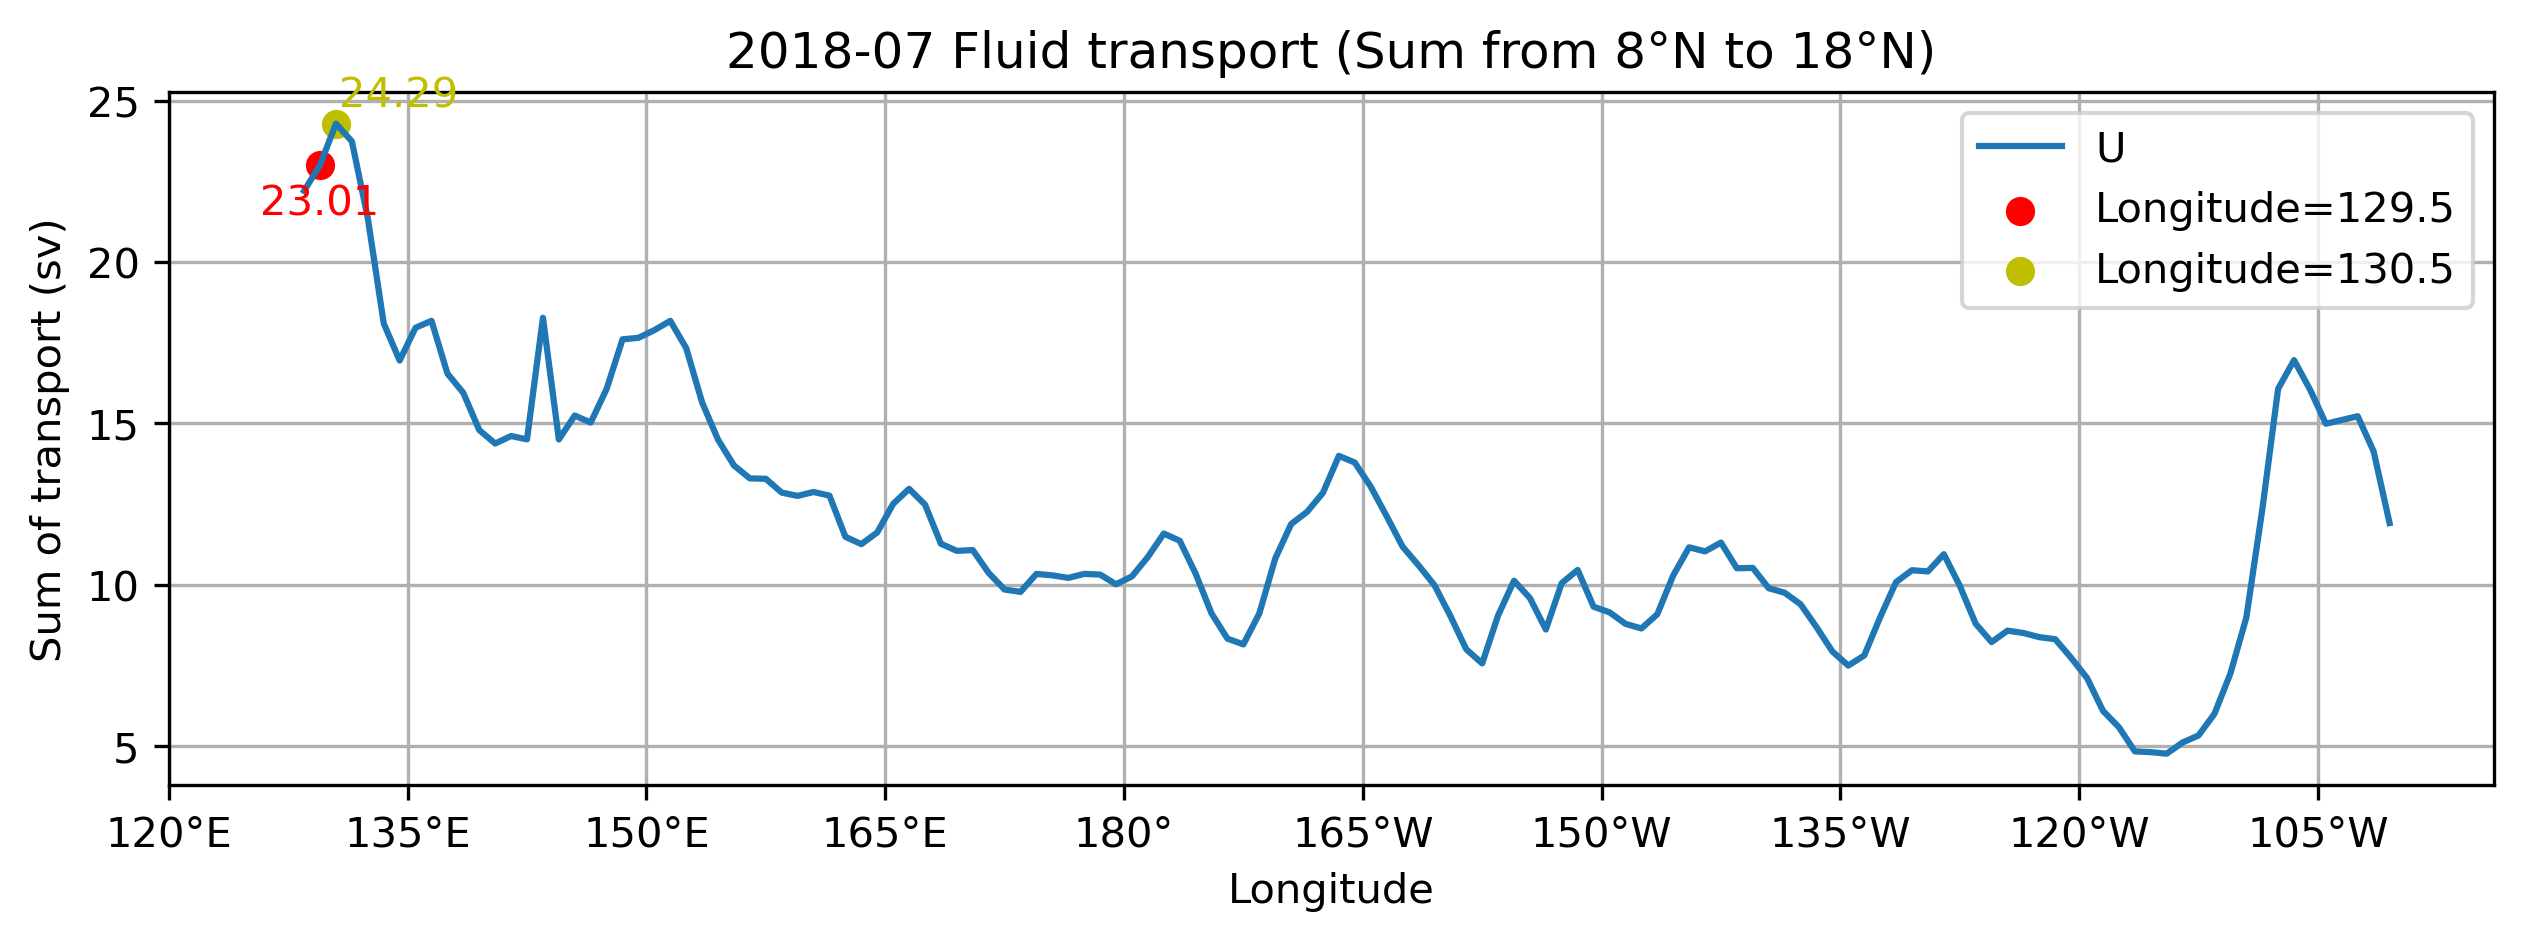

In [16]:
def calculate_flux_v1(v, lat, depth):
    """
    计算纬度平面的流水通量
    :param v: 垂直流速，二维numpy数组，行表示纬度，列表示深度
    :param lat: 纬度，一维numpy数组
    :param depth: 深度，一维numpy数组，单位为db
    :return: 纬度平面的流水通量，单位为sv
    """
    #print(v.shape)
    # 计算每个网格面积
    d_depth = np.diff(depth)
    area = getdy(lat)[:, np.newaxis] * d_depth[np.newaxis, :]
    flux = np.multiply(v[:-1,:-1].T, area)
    # 计算每个网格的流水通量
    return np.sum(flux)/10e6

latind=(lat>=8)&(lat<=18)
lat_t=lat[latind]
latind=(lat>=8)&(lat<=18)
lonind=(lon>=129)&(lon<=131)
lat_t=lat[latind]
ts_U = np.array([calculate_flux_v1((((U**2+V**2)**0.5)[:,latind,:][:,:,lon==i]),lat_t,lev) for i in lon])
#ts_V = np.array([calculate_flux_v1((V[:,latind,:][:,:,lon==i]),lat_t,lev) for i in lon])
plt.figure(figsize=(10,3),dpi=300)
plt.title('2018-07 Fluid transport (Sum from 8°N to 18°N)')
plt.plot(lon,ts_U,label='U')
plt.scatter(lon[lon==129.5],ts_U[lon==129.5],c='r',label='Longitude=129.5')
plt.scatter(lon[lon==130.5],ts_U[lon==130.5],c='y',label='Longitude=130.5')
plt.legend()
plt.annotate(
    f"{ts_U[lon == 129.5][0]:.2f}",
    (lon[lon == 129.5], ts_U[lon == 129.5]),
    textcoords="offset points",
    xytext=(0, -12),
    ha='center',
    c='r',
)
plt.annotate(
    f"{ts_U[lon == 130.5][0]:.2f}",
    (lon[lon == 130.5], ts_U[lon == 130.5]),
    textcoords="offset points",
    xytext=(15, 4),
    ha='center',
    c='y',
)
ax=plt.gca()
ax.get_xlim()
plt.xticks(np.arange(120,266,15),['120°E','135°E','150°E','165°E','180°','165°W','150°W','135°W','120°W','105°W'])
plt.xlabel('Longitude')
plt.ylabel('Sum of transport (sv)')
plt.grid()
np.save('ts_U_2018_07.npy',ts_U)

### <a id='toc1_4_6_'></a>[Visualization of Flow Velocity & Flow Field](#toc0_)

[None, None, None, None]

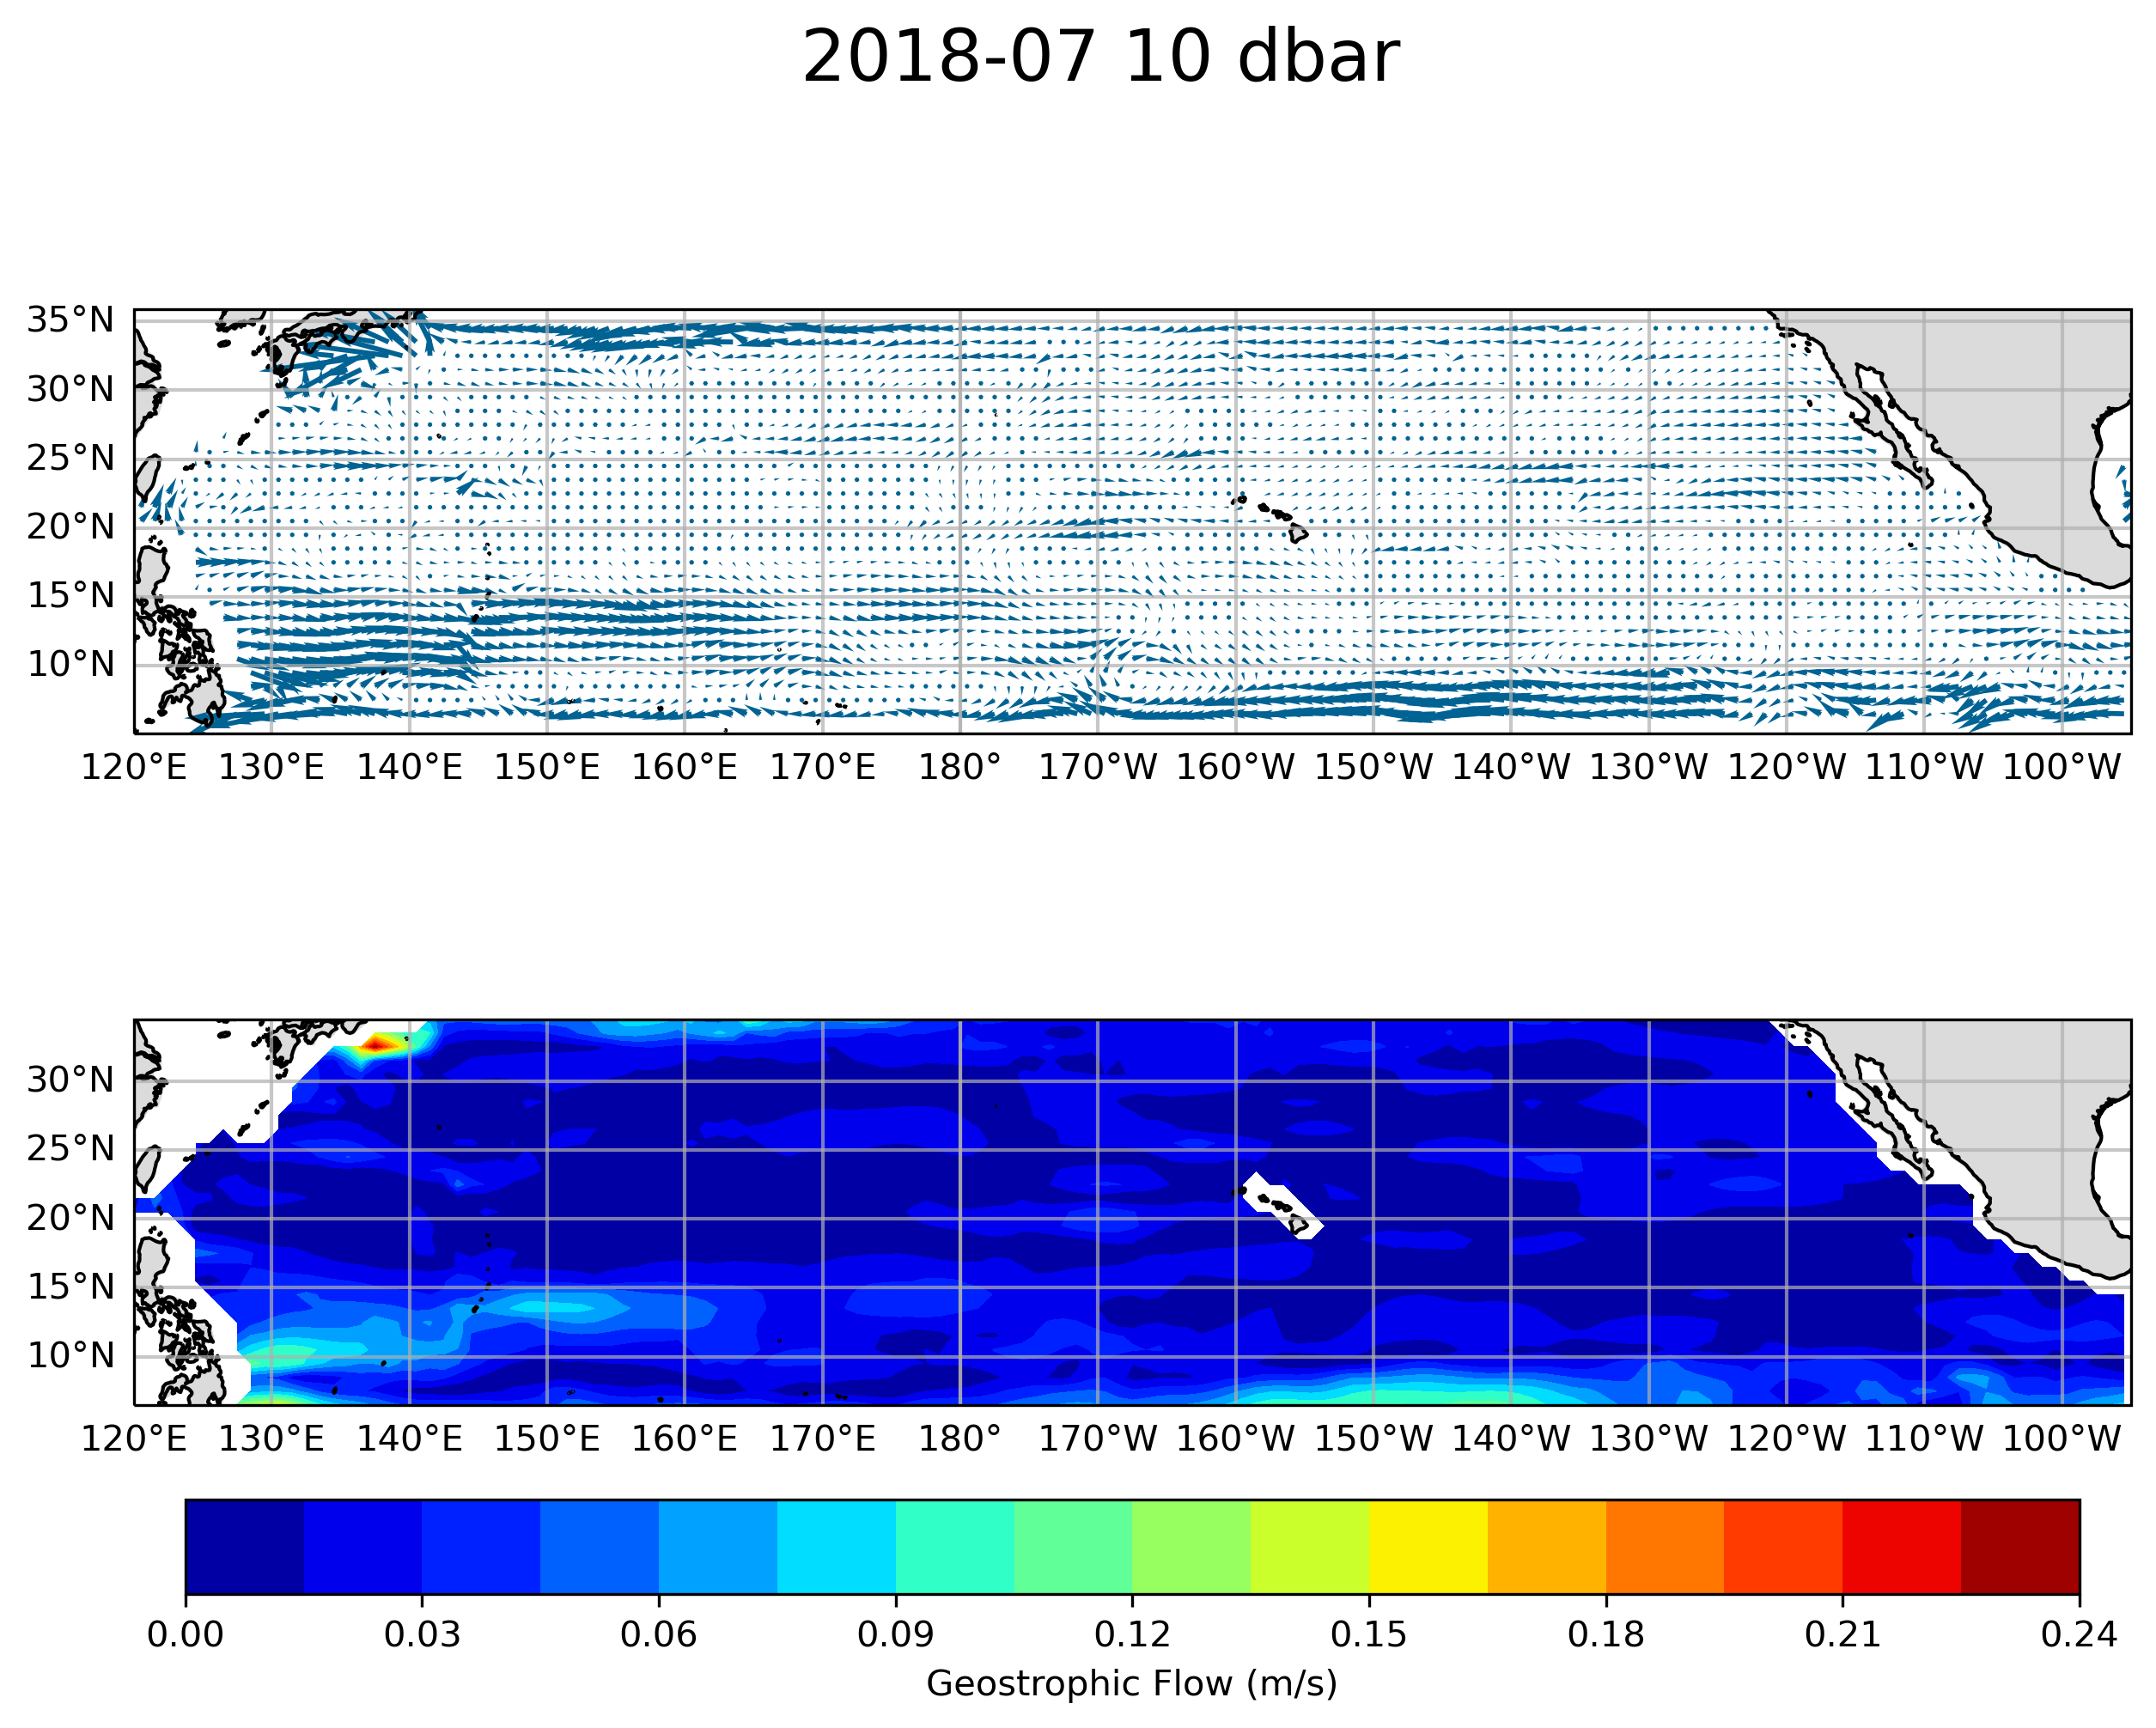

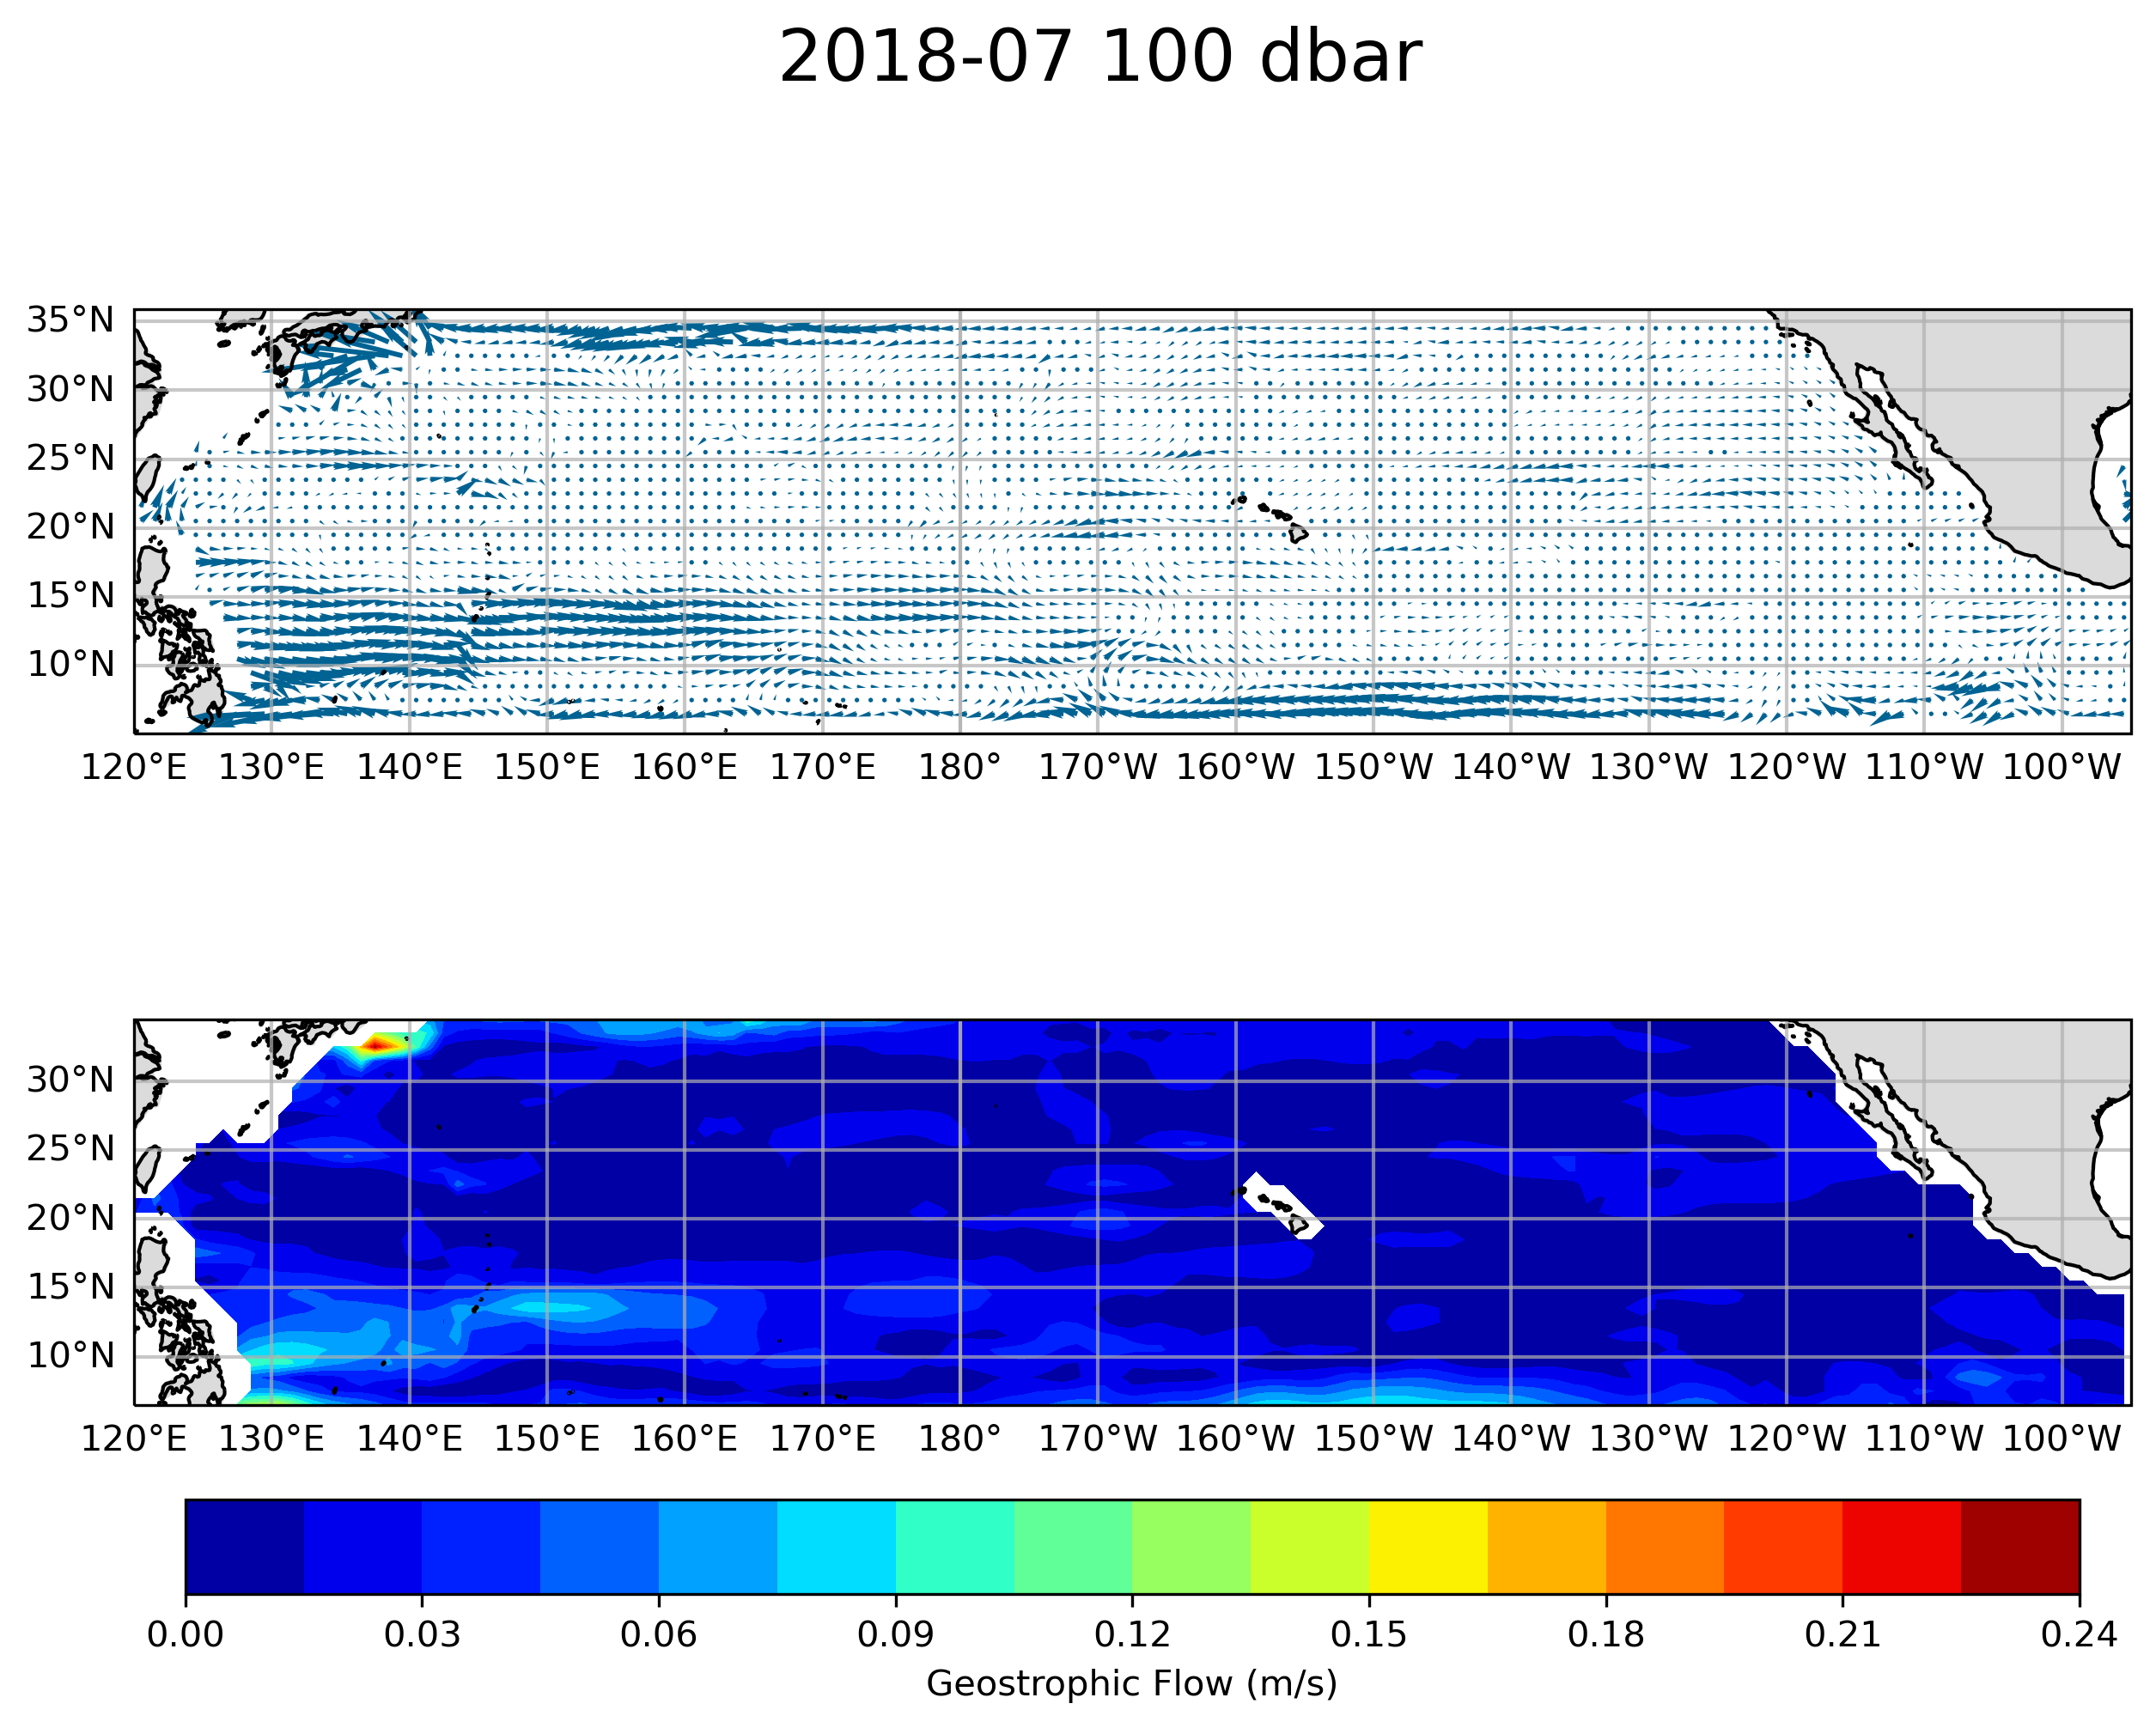

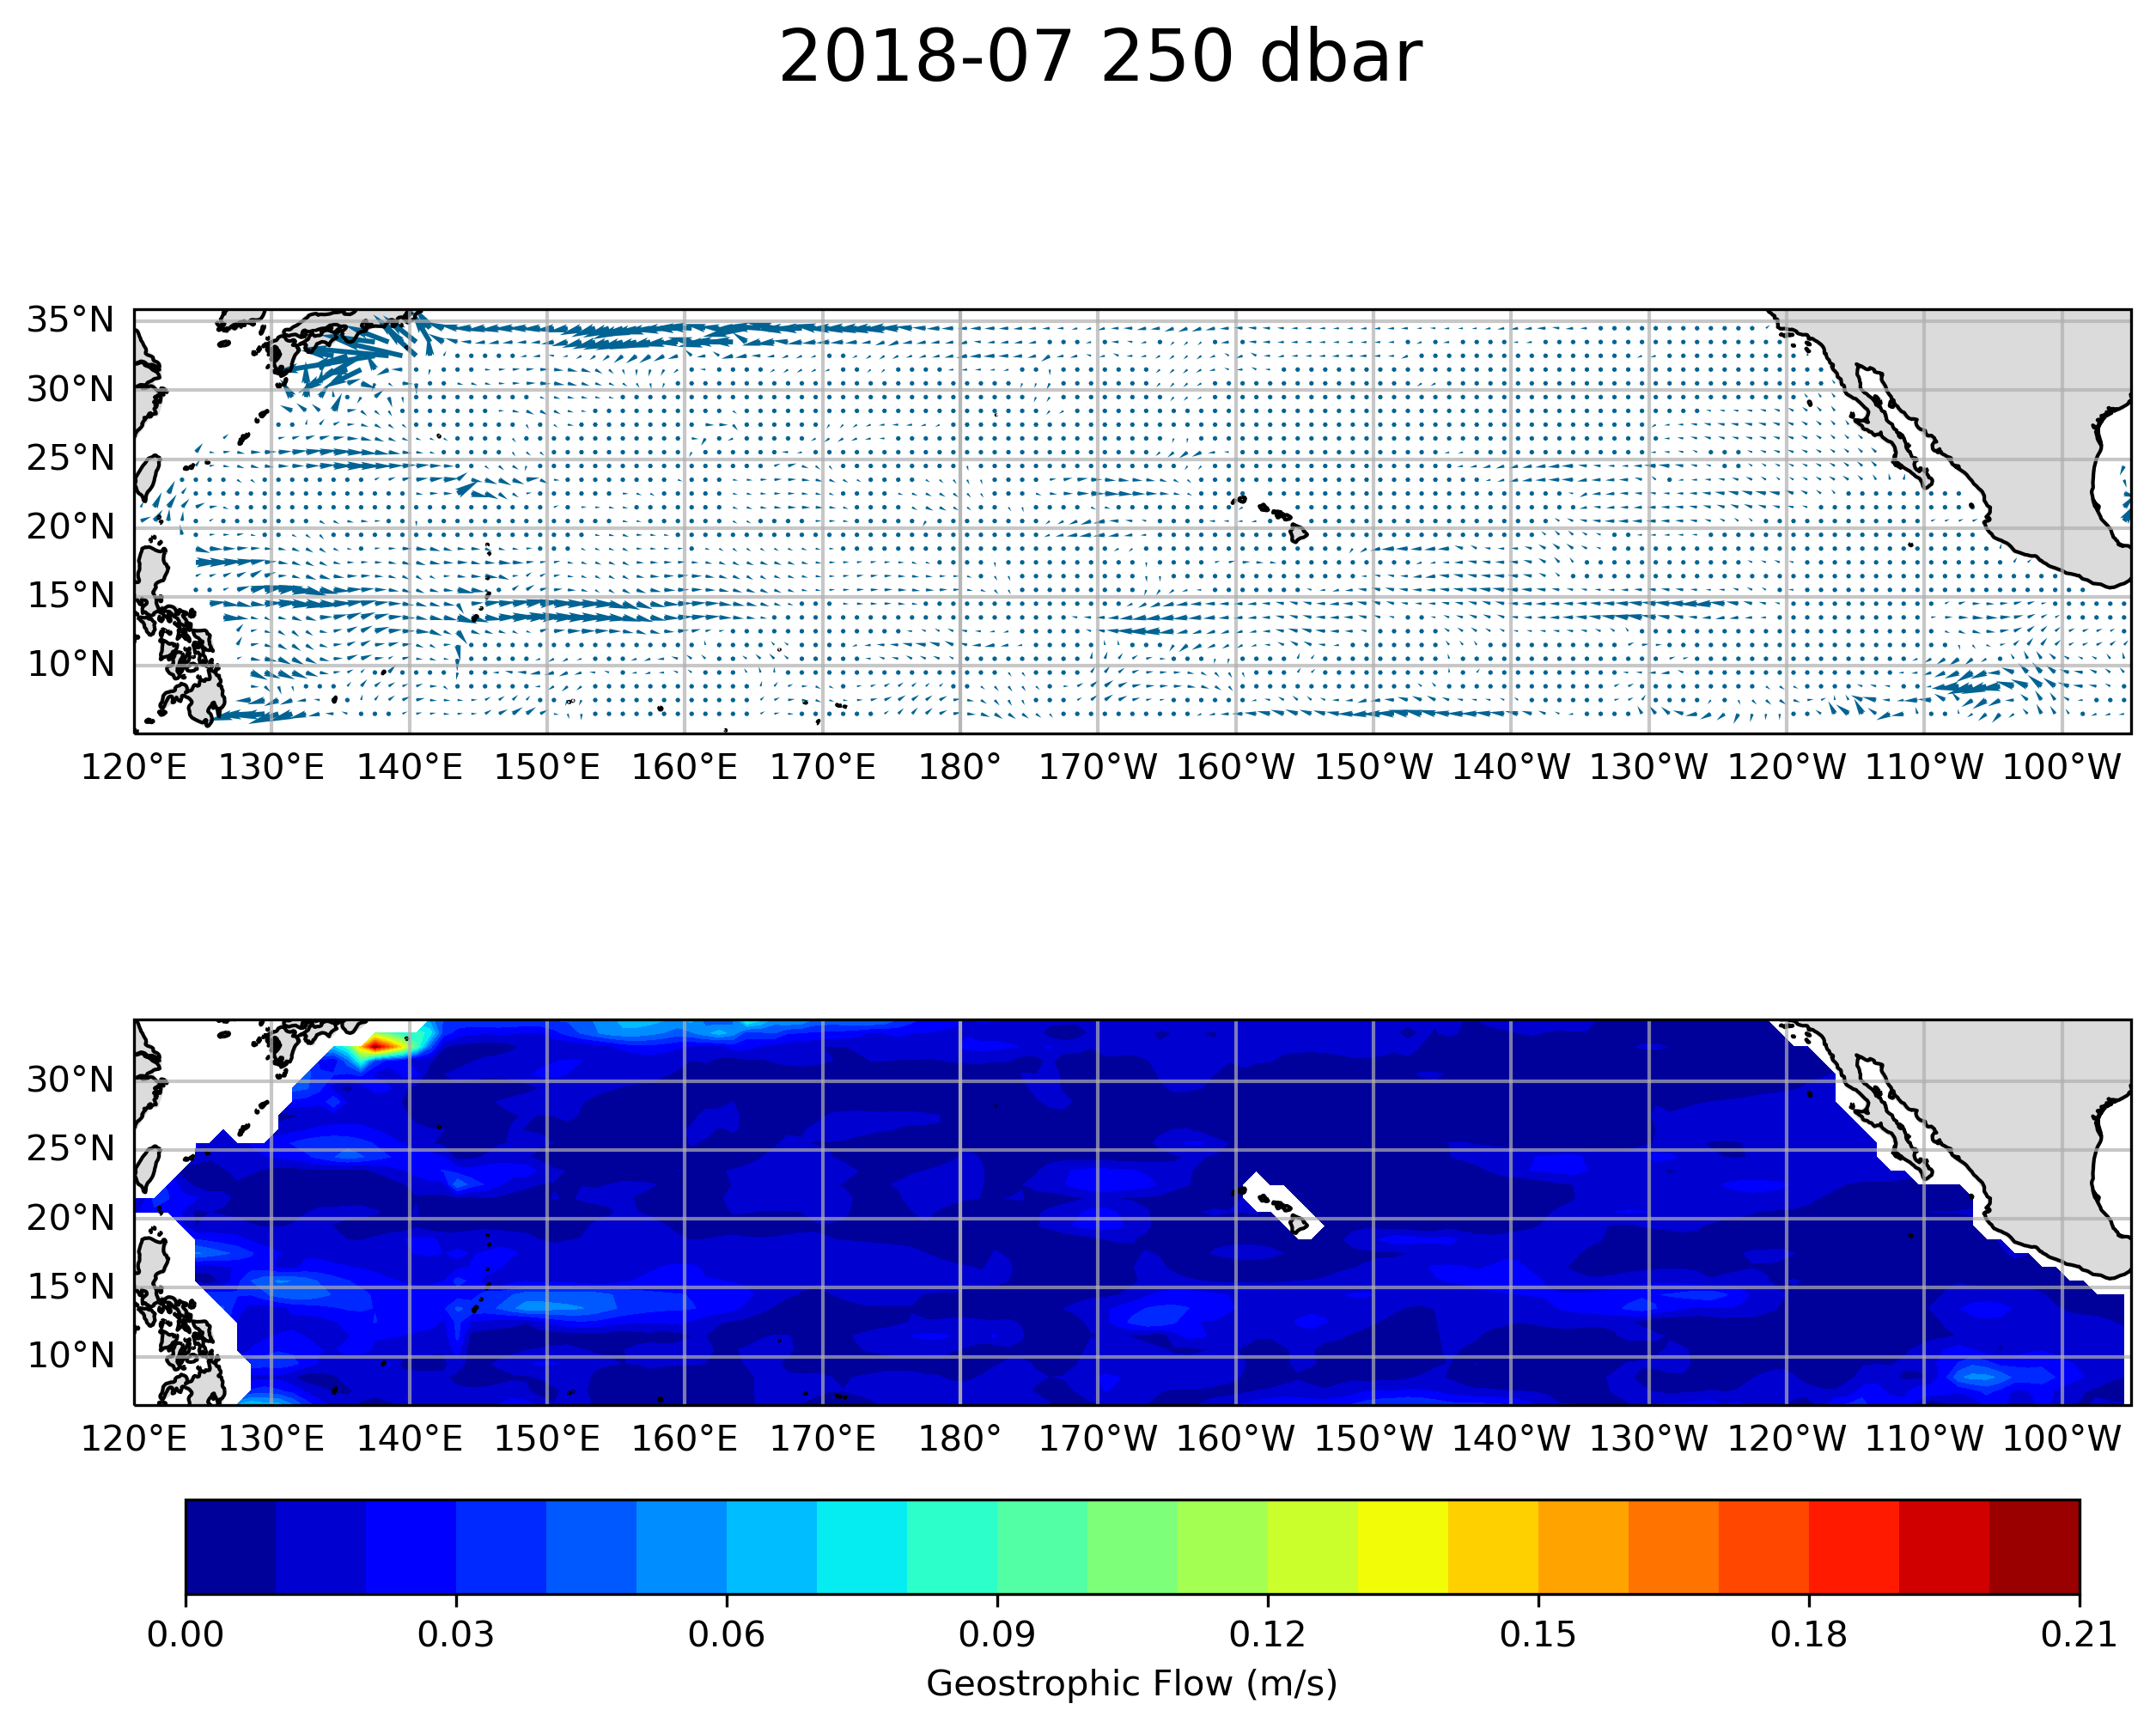

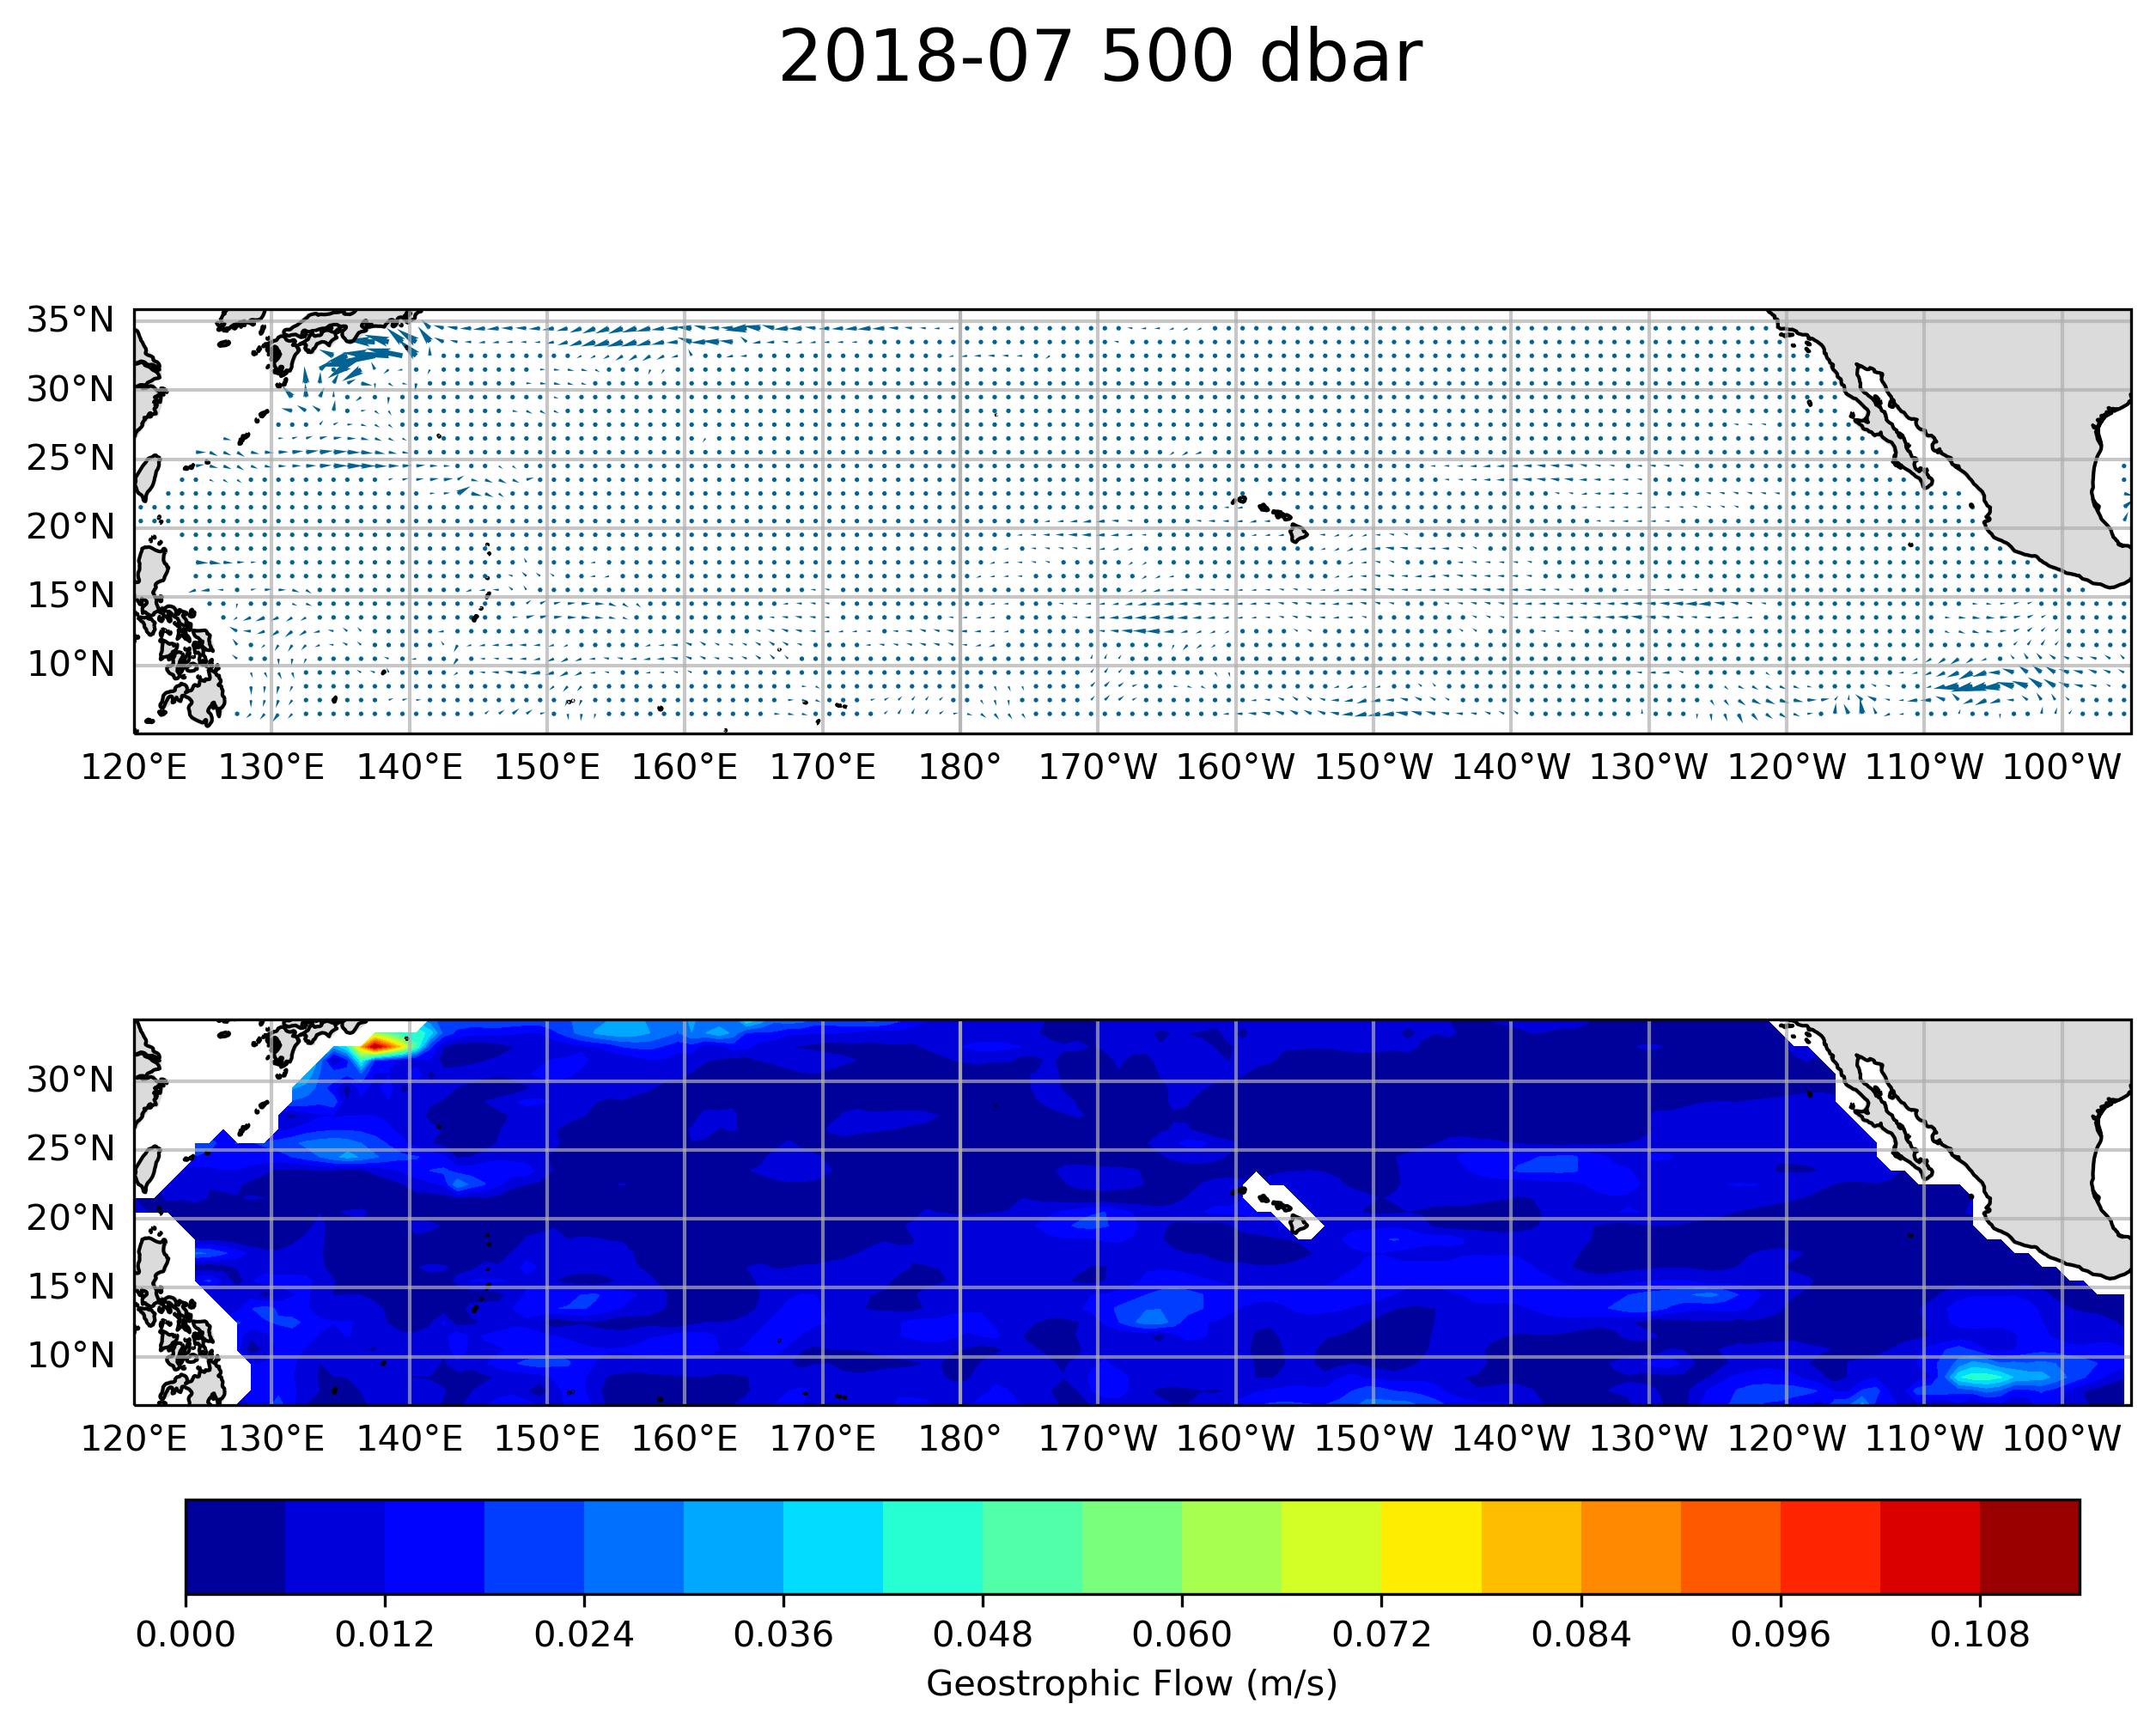

In [17]:

def draw(db):
    global U,V
    dbind=np.where(lev==db)[0][0]
    Lon,Lat=np.meshgrid(lon,lat)
    sep=1
    ig, axs = plt.subplots(2,1,figsize=(10,7),dpi=300,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    ig.suptitle(f'2018-07 {db} dbar',fontsize=20)
    for ax in axs:
        ax.coastlines()
        land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face',
                                        facecolor=cfeature.COLORS['land_alt1'])
        ax.add_feature(land, zorder=0)
        gl = ax.gridlines( draw_labels=True, linewidth=1, alpha=0.7)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = plt.MaxNLocator(37)
        ax.set_xlim(-60,85)
    # gl.ylocator = plt.MaxNLocator(6)
    axs[0].quiver(Lon[::sep,::sep],Lat[::sep,::sep],U[dbind,:,:][::sep,::sep],V[dbind,:,:][::sep,::sep],width=0.0025,headwidth=2,scale=4,transform=ccrs.PlateCarree(),color='#006393')
    c=axs[1].contourf(Lon,Lat,((U**2+V**2)**0.5)[dbind,:,:],20,cmap='jet',transform=ccrs.PlateCarree())
    plt.colorbar(c,orientation='horizontal',ax=axs[1],label='Geostrophic Flow (m/s)')
    plt.savefig(f'2018-07 {db} dbar.png',bbox_inches='tight')

dbs=[10,100,250,500]
[draw(db) for db in dbs]
# draw(500)
#ax.gridlines()
#plt.contourf(Lon,Lat,V[0,:,:],cmap='RdBu_r')
#plt.colorbar()

## <a id='toc1_5_'></a>[Compare](#toc0_)

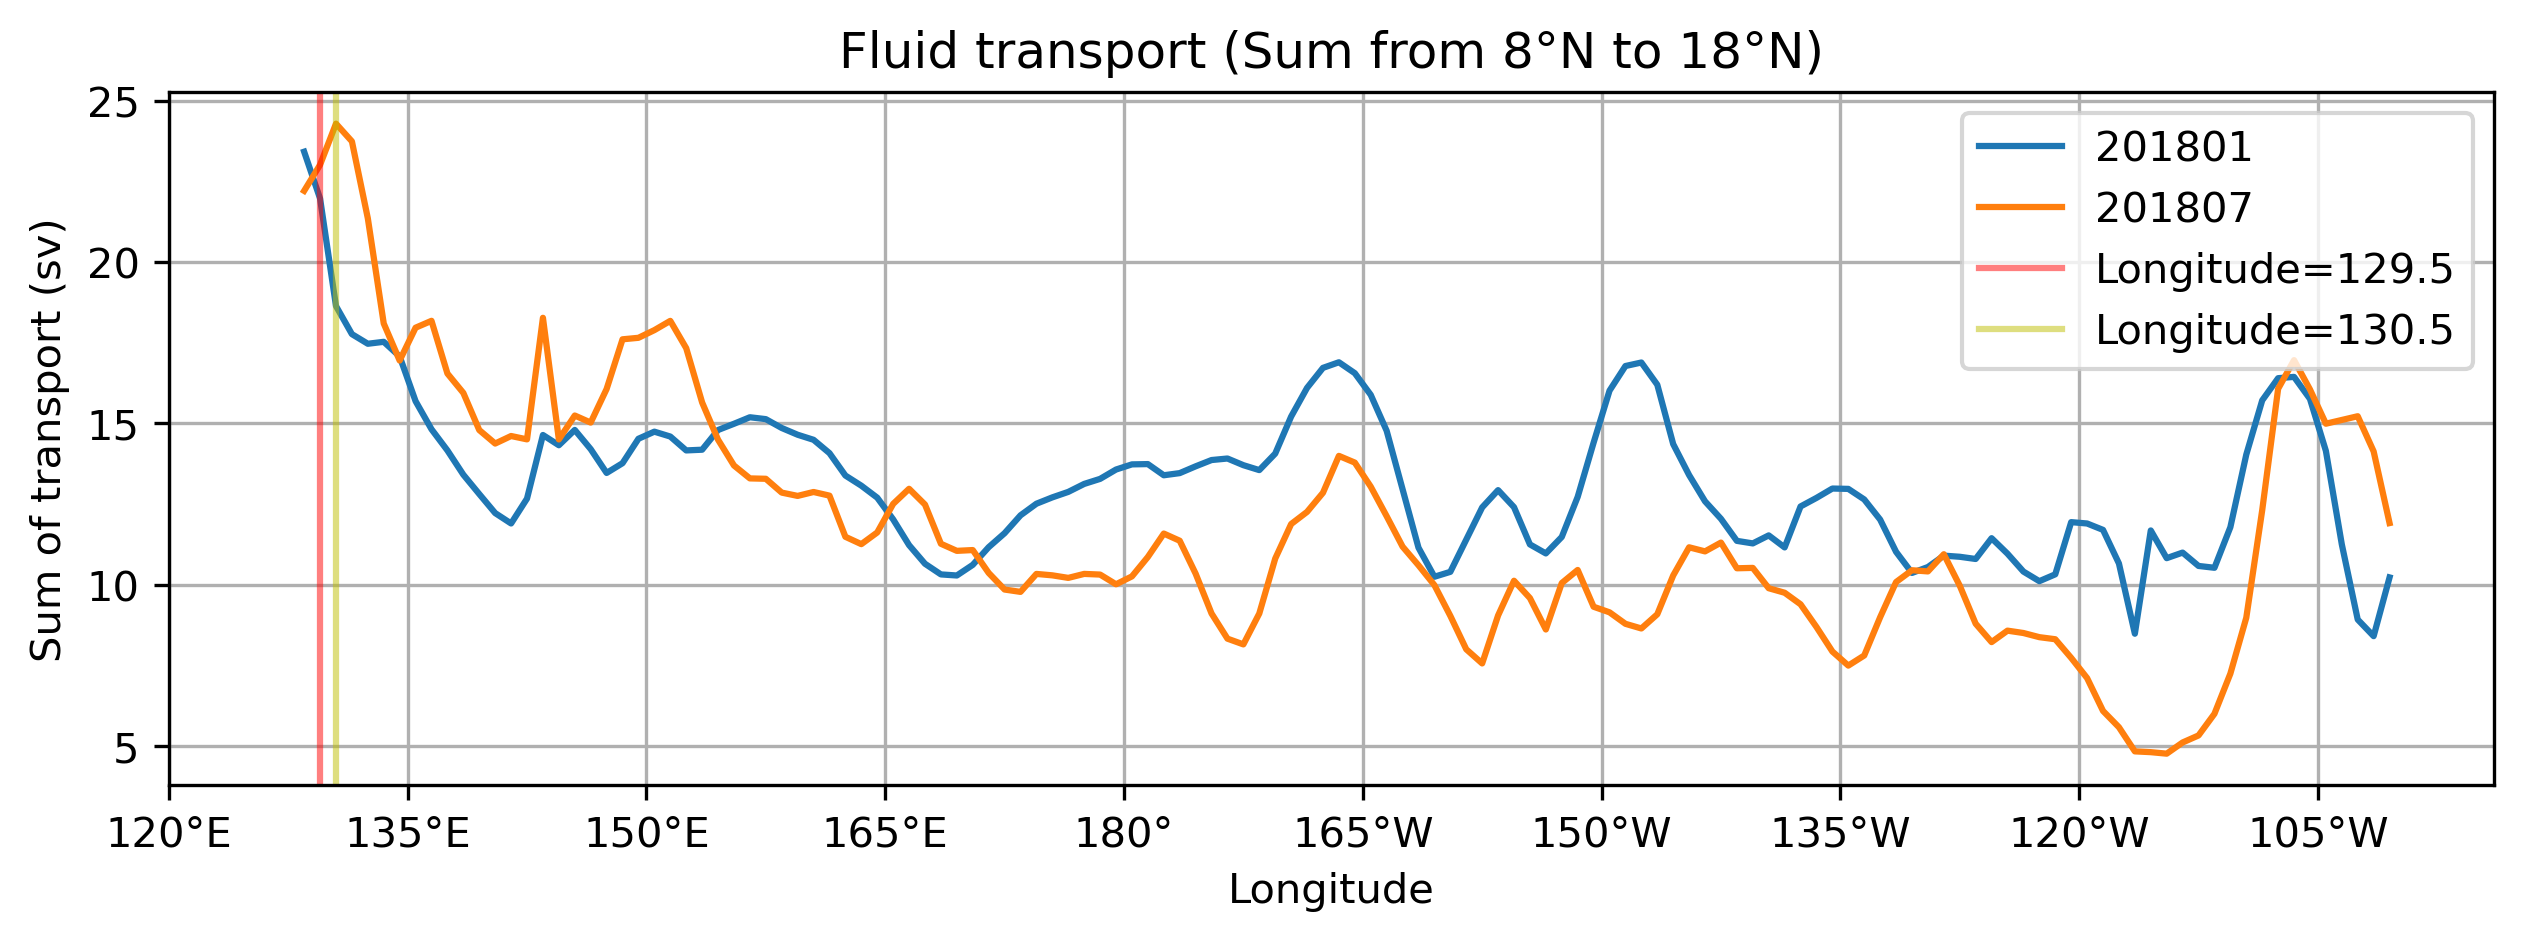

In [18]:
ts_U_2018_01=np.load('ts_U_2018_01.npy')
ts_U_2018_07=np.load('ts_U_2018_07.npy')
plt.figure(figsize=(10,3),dpi=300)
plt.title('Fluid transport (Sum from 8°N to 18°N)')
plt.plot(lon,ts_U_2018_01,label='201801')
plt.plot(lon,ts_U_2018_07,label='201807')
plt.axvline(x=129.5, color='r',alpha=0.5,label='Longitude=129.5')
plt.axvline(x=130.5, color='y',alpha=0.5,label='Longitude=130.5')
plt.xticks(np.arange(120,266,15),['120°E','135°E','150°E','165°E','180°','165°W','150°W','135°W','120°W','105°W'])
plt.xlabel('Longitude')
plt.ylabel('Sum of transport (sv)')
plt.grid()
plt.legend()

# System version

In [19]:
import sys
print(sys.version)
!pip list | grep gsw
!pip list | grep numpy
!pip list | grep netCDF4
!pip list | grep cartopy
!pip list | grep matplotlib



3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
gsw                            3.6.16.post1
numpy                          1.23.5
netCDF4                        1.6.2
matplotlib                     3.7.1
matplotlib-inline              0.1.6
